In [2]:
%run StoreTweetsBackend.ipynb

Growth SET
GPU ACTIVE
{'limit': 15, 'remaining': 15, 'reset': 1618916363}
{'limit': 900, 'remaining': 900, 'reset': 1618916363}
sentimentDB exists.
Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'sentimentDB')


# Sentiment

## Load Tweet Data

https://www.kaggle.com/omermetinn/tweets-about-the-top-companies-from-2015-to-2020

In [3]:
datasets=["Company.csv","Company_Tweet.csv","Tweet.csv"]
tweetdata= (pd.read_csv("D:/Downloads/archive (1)/{0}".format(datasets[2]),parse_dates=[0])).sort_values('post_date')
tweetdata=tweetdata.set_index(pd.to_datetime(tweetdata["post_date"], unit='s',utc=True).dt.date)
tweetdata=tweetdata.drop(columns=["writer","tweet_id",'post_date',"comment_num","retweet_num","like_num"])
# tweetdata=load("tweetdata")

Sentiment140

In [4]:
sentiment140Value=(getQueryFromMongoDB("sentiment140").sort_values('SentimentScore'))[["_id",'SentimentScore','tweetText']]
sentiment140Value=sentiment140Value.drop_duplicates(subset=['tweetText'], keep='last')
sentiment140Value=sentiment140Value.sample(frac=1)

## Creating a Tweet Preprocessor

## Preprocess Tweets

In [5]:
original3=["original3"]
cat2=["C2-bad","C2-good"]
sentiment140Value[original3]=sentiment140Value['SentimentScore'].replace({4: 1})
sentiment140Value[cat2]=to_categorical(sentiment140Value['SentimentScore'].replace({4: 1}))
allscores=[]
allscores.extend(cat2)
allscores.extend(original3)
allscores.extend(['SentimentScore'])  

In [6]:
pos=False
chnk=False
EMOJI=False

Preprocess and Store Tweets

In [347]:
# dataSubset=sentiment140Value
# dataSubset["processed"]=dataSubset["tweetText"].apply(lambda t: preprocess(t,pos,chnk,EMOJI))
# dataSubset=dataSubset.drop_duplicates(subset=["processed"], keep='last')
# insertDFToDB("Sentiment140P"+str(pos)[0]+str(chnk)[0]+str(EMOJI)[0],dataSubset.sort_values(by=['_id']))

Retrieve Tweets From DB

In [348]:
dataSubset=getQueryFromMongoDB("Sentiment140P"+str(pos)[0]+str(chnk)[0]+str(EMOJI)[0]).sort_values('_id')
dataSubset=dataSubset.drop_duplicates(subset=['processed'], keep='last')
dataSubset=dataSubset.sample(frac=1)

In [349]:
trainX, testX, trainY, testY =train_test_split(dataSubset["processed"], dataSubset[allscores],shuffle=True, test_size=0.2,random_state=0)

In [350]:
len(dataSubset),len(trainX),len(testX)

(1518175, 1214540, 303635)

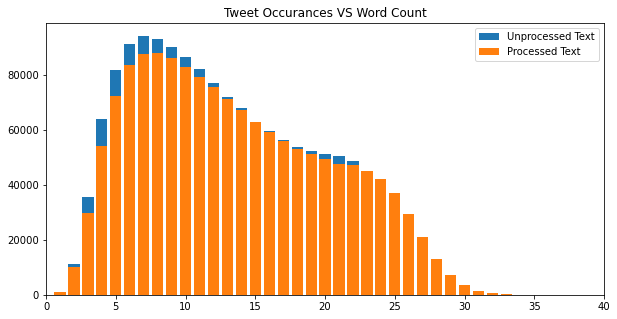

In [359]:
dataSubset["len"]=dataSubset["processed"].apply(lambda x:len(x.split()))
dataSubset["len2"]=dataSubset["tweetText"].apply(lambda x:len(x.split()))
ppp,pp=dataSubset["len"].value_counts(),dataSubset["len2"].value_counts()
plt.figure(figsize=(10,5))
plt.title("Tweet Occurances VS Word Count"  )
plt.bar(ppp.index,ppp,label="Unprocessed Text")
plt.bar(pp.index,pp,label="Processed Text")
plt.xlim([0, 40])
plt.legend()

### Text Preprocessing

In [31]:
dataSubset=dataSubset[(dataSubset[["positive","negative"]].max(axis=1)>0.5)]
dataSubset["label"]=dataSubset[["positive","negative"]].idxmax(axis=1)
# dataSubset[dataSubset["label"]=="positive"][:100]["tweetText"].to_csv("pos.csv")
# dataSubset[dataSubset["label"]=="negative"][:100]["tweetText"].to_csv("neg.csv")

267266    negative
220331    negative
366301    negative
112815    negative
183969    positive
            ...   
122498    positive
77652     negative
41312     negative
48251     negative
179547    negative
Name: label, Length: 485741, dtype: object

## Testing Various Models 

In [27]:
params = [(1,1),(1,2),(1,3)]
result=pd.DataFrame(columns=["model","ngram","POS","Chunking","Emoji","Precision","Recall", "Accuracy","MCC","AUC"])

### Multinomial Naive Bayes

In [16]:
for param in params:
    print("MNB_NGRAM: "+str(param))
    model = Pipeline([('bow', CountVectorizer(max_features=None,preprocessor=None,ngram_range=param,lowercase=False)),
                      ('tfidf', TfidfTransformer()), 
                      ('classifier', MultinomialNB()),])
    model.fit(trainX.values, trainY[original3].values.flatten())
    pred=model.predict(testX.values)
    per,rec,f1=metrics.precision_recall_fscore_support(testY[original3].values,pred, average='micro')[:3]
    result.loc[result.index.max()+1]=["MNB",str(param),pos,chnk,EMOJI,matthews_corrcoef(testY[original3].values,pred),per,rec,f1,metrics.roc_auc_score(testY[original3].values,pred)]

MNB_NGRAM: (1, 1)
MNB_NGRAM: (1, 2)
MNB_NGRAM: (1, 3)


### Logisitic Regression

In [20]:
for param in params:
    print("LR_NGRAM: "+str(param))
    model = Pipeline([('bow', CountVectorizer(max_features=None,preprocessor=None,ngram_range=param,lowercase=False)),('tfidf', TfidfTransformer()),('classifier',LogisticRegression()),])    
    model.fit(trainX.values, trainY[original3].values.flatten())
    pred=model.predict(testX.values)
    per,rec,f1=metrics.precision_recall_fscore_support(testY[original3].values,pred, average='micro')[:3]
    result.loc[result.index.max()+1]=["LR",str(param),pos,chnk,EMOJI,matthews_corrcoef(testY[original3].values,pred),per,rec,f1,metrics.roc_auc_score(testY[original3].values,pred)]

### DNN

In [ ]:
vec_layer = TextVectorization(ngrams=2,max_tokens=None,output_sequence_length=50)
vec_layer.adapt(trainX.tolist())

In [ ]:
tf.keras.backend.clear_session()
def DNN(sequence_length = 60, embedding_dim=16,optimizer='adam'):
    M = Sequential([vec_layer, 
                    Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True),
                    Dense(16, activation="elu"),
                    Flatten(),
                    Dense(16, activation="elu"),
                    Dense(2,activation='softmax')])
    M.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"]) 
    return M

In [ ]:
tf.get_logger().setLevel('ERROR')
for param in params:
    tf.keras.backend.clear_session()
    vec_layer = TextVectorization(ngrams=param,max_tokens=None,output_sequence_length=50)
    vec_layer.adapt(trainX.tolist())
    model =DNN( sequence_length = 50, embedding_dim=16,optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.6, beta_2=0.999, epsilon=1e-06))
    model.fit(trainX, trainY[cat2],epochs=1, batch_size=10000, validation_data=(testX,testY[cat2]), callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=0)])
    pred=pd.DataFrame( model.predict(testX),columns=[0,1]).idxmax(axis=1) 
    per,rec,f1=metrics.precision_recall_fscore_support(testY[original3].values,pred, average='micro')[:3]
    result.loc[result.index.max()+1]=["DNN",str(param),pos,chnk,EMOJI,matthews_corrcoef(testY[original3].values,pred),per,rec,f1,metrics.roc_auc_score(testY[original3].values,pred)]
    result.to_csv("sentimentResults.csv")

### LSTM

In [ ]:
tf.keras.backend.clear_session()
callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=3)]
def LSTM_model(sequence_length = 140, embedding_dim=16, optimizer='adam',hidden=16):
    M = Sequential([vec_layer,
                    Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True),
                    LSTM(hidden, 'elu', return_sequences =True),
                    LSTM(hidden,'elu', return_sequences =False),
                    Dense(10,activation='elu'),
                    Dense(2,activation='softmax')])
    M.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"]) 
    return M

In [ ]:
tf.get_logger().setLevel('ERROR')
for param in params:
    tf.keras.backend.clear_session()
    vec_layer = TextVectorization(ngrams=param,max_tokens=None,output_sequence_length=50)
    vec_layer.adapt(trainX.tolist())
    model =LSTM_model(sequence_length = 50, embedding_dim=16,hidden=30,optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))
    model.fit(trainX, trainY[cat2],epochs=2, batch_size=10000, validation_data=(testX,testY[cat2]), callbacks=callbacks)
    pred=pd.DataFrame( model.predict(testX),columns=[0,1]).idxmax(axis=1) 
    per,rec,f1=metrics.precision_recall_fscore_support(testY[original3].values,pred, average='micro')[:3]
    result.loc[result.index.max()+1]=["LSTM",str(param),pos,chnk,EMOJI,matthews_corrcoef(testY[original3].values,pred),per,rec,f1,metrics.roc_auc_score(testY[original3].values,pred)]
    result.to_csv("sentimentResults.csv")

### Transformer Encoder

In [2]:
tf.keras.backend.clear_session()
def Transformer_Encoder_Model(optimizer=tf.keras.optimizers.Adam(lr=0.001), hidden=16,embedding_dim=16,encoders=3,key_dim=16,dropout=0.2):
    x =Input(shape=(1,), dtype=tf.string)
    V =vec_layer(x)    
    E=Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True)(V)#try with or without masking
    E=ScalerMult(embedding_dim)(E)
    P=PositionalEncoding(len(vec_layer.get_vocabulary()),embedding_dim)(E)
    p=Masking()(P)#with and without
    out=Encoder(embedding_dim,encoders,hidden,P,key_dim,dropout=dropout,axis=1)
    out=Flatten()(out)
    out=Dense(2,'linear')(out)
    out=Dense(2,'softmax')(out)
    M=tf.keras.models.Model(inputs=x,outputs=out) 
    M.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])  
    return M

In [ ]:
tf.get_logger().setLevel('ERROR')
for param in params:
    tf.keras.backend.clear_session()
    vec_layer = TextVectorization(ngrams=param,max_tokens=None,output_sequence_length=50)
    vec_layer.adapt(trainX.tolist())
    model =Transformer_Encoder_Model(tf.keras.optimizers.Adam(lr=0.001),50,16,3,16,0.4)
    model.fit(trainX, trainY[cat2],epochs=1, batch_size=1000, validation_data=(testX,testY[cat2]))
    pred=pd.DataFrame( model.predict(testX),columns=[0,1]).idxmax(axis=1) 
    per,rec,f1=metrics.precision_recall_fscore_support(testY[original3].values,pred, average='micro')[:3]
    result.loc[result.index.max()+1]=["TFENC",str(param),pos,chnk,EMOJI,matthews_corrcoef(testY[original3].values,pred),per,rec,f1,metrics.roc_auc_score(testY[original3].values,pred)]
    result.to_csv("sentimentResults.csv")

In [ ]:
result=result.sort_values(["model","ngram","POS","Chunking","Emoji"])
result=result.reset_index(drop=True)

In [28]:
# result.result_("sentimentResults.csv")
# pd.read_csv("res.csv",index_col=0).sort_values(by="AUC")

In [364]:
rrrr=pd.read_csv("res.csv",index_col=0).sort_values(by="AUC")
print(rrrr.sort_values(["AUC"],ascending=False).reset_index(drop=True).to_latex())

\begin{tabular}{llllllrrrrr}
\toprule
{} &  model &   ngram &    POS &  Chunking &  Emoji &  Precision &    Recall &  Accuracy &       MCC &       AUC \\
\midrule
0  &  TFENC &  (1, 2) &  False &     False &  False &   0.650917 &  0.825178 &  0.825178 &  0.825178 &  0.824998 \\
1  &     LR &  (1, 3) &  False &     False &  False &   0.644618 &  0.822319 &  0.822319 &  0.822319 &  0.822308 \\
2  &     LR &  (1, 2) &  False &     False &  False &   0.644169 &  0.822029 &  0.822029 &  0.822029 &  0.822080 \\
3  &  TFENC &  (1, 3) &  False &     False &  False &   0.642711 &  0.821265 &  0.821265 &  0.821265 &  0.821147 \\
4  &  TFENC &  (1, 2) &   True &      True &  False &   0.636388 &  0.817930 &  0.817930 &  0.817930 &  0.817788 \\
5  &     LR &  (1, 2) &   True &     False &  False &   0.633082 &  0.816516 &  0.816516 &  0.816516 &  0.816550 \\
6  &     LR &  (1, 2) &   True &      True &  False &   0.631338 &  0.815645 &  0.815645 &  0.815645 &  0.815669 \\
7  &     LR &  (1, 3) &  

In [272]:
selector=rrrr["POS"]==False
rrrr[selector].sort_values(["model","ngram","POS","Chunking"])

,model,ngram,POS,Chunking,Emoji,Precision,Recall,Accuracy,MCC,AUC
0,DNN,"(1, 1)",False,False,False,0.585708,0.792066,0.792066,0.792066,0.792307
2,DNN,"(1, 2)",False,False,False,0.614446,0.804939,0.804939,0.804939,0.804464
4,DNN,"(1, 3)",False,False,False,0.607775,0.802838,0.802838,0.802838,0.803117
6,LR,"(1, 1)",False,False,False,0.597136,0.798481,0.798481,0.798481,0.798548
9,LR,"(1, 2)",False,False,False,0.644169,0.822029,0.822029,0.822029,0.822080
12,LR,"(1, 3)",False,False,False,0.644618,0.822319,0.822319,0.822319,0.822308
15,LSTM,"(1, 1)",False,False,False,0.612435,0.806228,0.806228,0.806228,0.806217
17,LSTM,"(1, 2)",False,False,False,0.591337,0.794350,0.794350,0.794350,0.793972
19,LSTM,"(1, 3)",False,False,False,0.473646,0.714310,0.714310,0.714310,0.712708
21,MNB,"(1, 1)",False,False,False,0.544251,0.772059,0.772059,0.772059,0.771934


<AxesSubplot:>

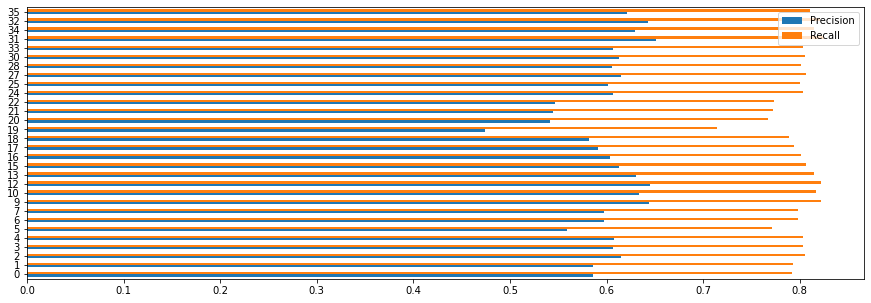

In [273]:
rrrr[rrrr["Chunking"]==False].sort_values(["model","ngram","POS","Chunking"])[["Precision","Recall"]].plot(kind="barh",)

In [280]:
rrrr.index=(rrrr[["model","ngram","POS","Chunking"]]).apply(lambda x:x[0]+x[1]+str(x[2])[0]+str(x[3])[0],axis=1)
rrrr.sort_values(["AUC","model","ngram","POS","Chunking"])

,model,ngram,POS,Chunking,Emoji,Precision,Recall,Accuracy,MCC,AUC
"LSTM(1, 3)FF",LSTM,"(1, 3)",False,False,False,0.473646,0.714310,0.714310,0.714310,0.712708
"LSTM(1, 3)TF",LSTM,"(1, 3)",True,False,False,0.541669,0.767113,0.767113,0.767113,0.767719
"DNN(1, 3)TF",DNN,"(1, 3)",True,False,False,0.559226,0.770740,0.770740,0.770740,0.771268
"MNB(1, 1)FF",MNB,"(1, 1)",False,False,False,0.544251,0.772059,0.772059,0.772059,0.771934
"MNB(1, 1)TF",MNB,"(1, 1)",True,False,False,0.546110,0.772898,0.772898,0.772898,0.772707
"MNB(1, 1)TT",MNB,"(1, 1)",True,True,False,0.547077,0.773309,0.773309,0.773309,0.773175
"DNN(1, 2)TT",DNN,"(1, 2)",True,True,False,0.585390,0.789116,0.789116,0.789116,0.788623
"LSTM(1, 2)TF",LSTM,"(1, 2)",True,False,False,0.581940,0.789333,0.789333,0.789333,0.789730
"DNN(1, 1)TT",DNN,"(1, 1)",True,True,False,0.583685,0.791254,0.791254,0.791254,0.791427
"DNN(1, 1)FF",DNN,"(1, 1)",False,False,False,0.585708,0.792066,0.792066,0.792066,0.792307


<AxesSubplot:>

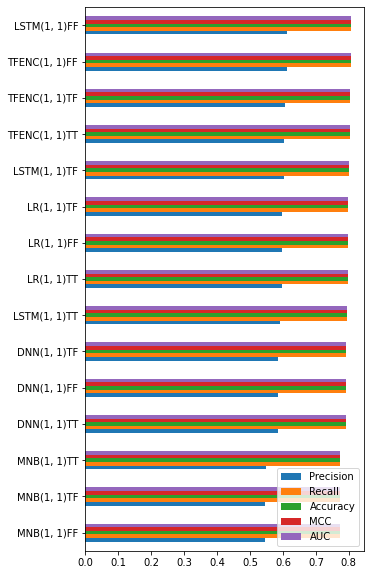

In [297]:
rrrr[rrrr["ngram"]=="(1, 1)"].sort_values(["AUC","model","ngram","POS","Chunking"])[["Precision","Recall","Accuracy","MCC","AUC"]].plot(kind="barh",figsize=(5,10))

In [302]:
rrrr[rrrr["POS"]==False].sort_values(["AUC","model","ngram","POS","Chunking"])[["Precision","Recall","Accuracy","MCC","AUC"]]

,Precision,Recall,Accuracy,MCC,AUC
"LSTM(1, 3)FF",0.473646,0.714310,0.714310,0.714310,0.712708
"MNB(1, 1)FF",0.544251,0.772059,0.772059,0.772059,0.771934
"DNN(1, 1)FF",0.585708,0.792066,0.792066,0.792066,0.792307
"LSTM(1, 2)FF",0.591337,0.794350,0.794350,0.794350,0.793972
"LR(1, 1)FF",0.597136,0.798481,0.798481,0.798481,0.798548
"MNB(1, 2)FF",0.607141,0.802936,0.802936,0.802936,0.802668
"DNN(1, 3)FF",0.607775,0.802838,0.802838,0.802838,0.803117
"DNN(1, 2)FF",0.614446,0.804939,0.804939,0.804939,0.804464
"TFENC(1, 1)FF",0.612620,0.805680,0.805680,0.805680,0.805415
"LSTM(1, 1)FF",0.612435,0.806228,0.806228,0.806228,0.806217


<ipython-input-319-3687a6af0db8>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  copy=rrrr[rrrr["POS"]==True][rrrr["Chunking"]==False].sort_values("AUC")


<AxesSubplot:>

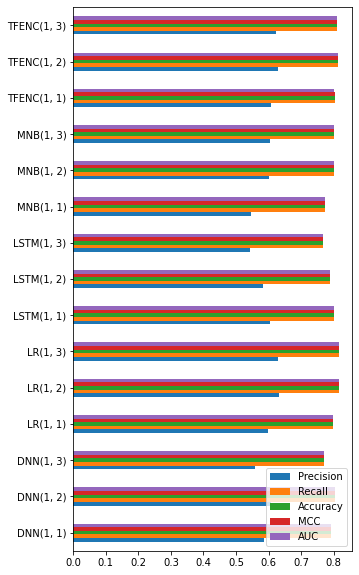

In [319]:
copy=rrrr[rrrr["POS"]==True][rrrr["Chunking"]==False].sort_values("AUC")
copy.index=(copy[["model","ngram"]]).apply(lambda x:x[0]+x[1],axis=1)
copy.sort_values(["model","ngram"])[["Precision","Recall","Accuracy","MCC","AUC"]].plot(kind="barh",figsize=(5,10))

In [334]:
copy=rrrr[rrrr["POS"]==False][rrrr["Chunking"]==False].sort_values("AUC")
copy.index=(copy[["model","ngram"]]).apply(lambda x:x[0]+x[1],axis=1)
#
# copy
copy.sort_values(["model","ngram"],ascending=False)[["Precision","Recall","Accuracy","MCC","AUC"]].to_csv("results.csv")

<ipython-input-334-1fb7505f46f9>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  copy=rrrr[rrrr["POS"]==False][rrrr["Chunking"]==False].sort_values("AUC")


In [326]:
selector=rrrr["POS"]==False
# selector=rrrr["Chunking"]==True
rrrr[selector].sort_values("AUC",ascending=False)[["Precision","Recall","Accuracy","MCC","AUC"]]


,Precision,Recall,Accuracy,MCC,AUC
"TFENC(1, 2)FF",0.650917,0.825178,0.825178,0.825178,0.824998
"LR(1, 3)FF",0.644618,0.822319,0.822319,0.822319,0.822308
"LR(1, 2)FF",0.644169,0.822029,0.822029,0.822029,0.822080
"TFENC(1, 3)FF",0.642711,0.821265,0.821265,0.821265,0.821147
"MNB(1, 3)FF",0.614678,0.806519,0.806519,0.806519,0.806221
"LSTM(1, 1)FF",0.612435,0.806228,0.806228,0.806228,0.806217
"TFENC(1, 1)FF",0.612620,0.805680,0.805680,0.805680,0.805415
"DNN(1, 2)FF",0.614446,0.804939,0.804939,0.804939,0.804464
"DNN(1, 3)FF",0.607775,0.802838,0.802838,0.802838,0.803117
"MNB(1, 2)FF",0.607141,0.802936,0.802936,0.802936,0.802668


Training the best model with all the data

In [33]:
vec_layer = TextVectorization(ngrams=2,max_tokens=None,output_sequence_length=60)
vec_layer.adapt(dataSubset["processed"].tolist())
# model =Transformer_Encoder_Model(tf.keras.optimizers.Adam(lr=0.001),50,16,3,16,0.4)
# model.fit(dataSubset["processed"], dataSubset[cat2],epochs=1, batch_size=1000)

1519/1519 [==============================] - 656s 430ms/step - loss: 0.5374 - accuracy: 0.7318


In [34]:
model.evaluate(dataSubset["processed"], dataSubset[cat2], batch_size=1000)

1519/1519 [==============================] - 114s 75ms/step - loss: 0.2693 - accuracy: 0.8905


[0.26926058530807495, 0.8905245065689087]

In [43]:
model.save_weights("/modelweights/transformerNLP")

In [11]:
vec_layer = TextVectorization(ngrams=2,max_tokens=None,output_sequence_length=60)
vec_layer.adapt(dataSubset["processed"].tolist())
model=Transformer_Encoder_Model(tf.keras.optimizers.Adam(lr=0.001),50,16,3,16,0.4)
model.load_weights("/modelweights/transformerNLP")
model.evaluate(dataSubset["processed"], dataSubset[cat2], batch_size=1000)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [47]:
dataSubset=getQueryFromMongoDB("Unprocessed").sort_values('_id')
dataSubset["processed"]=dataSubset["tweetText"].apply(lambda t: preprocess(t,pos,chnk,EMOJI))
dataSubset=dataSubset.drop_duplicates(subset=['processed'], keep='last')
dataSubset=dataSubset.sample(frac=1)

In [49]:
dataSubset[["positive","negative"]]=model.predict(dataSubset["processed"])

In [59]:
insertDFToDB("ProcessedTweets",dataSubset.sort_values(by=['_id']))eee

## Training & evaluating a model

In [ ]:
# sentiment140Value=(getQueryFromMongoDB("processedSentiment140"))[["_id",'SentimentScore','processed']]
# sentiment140Value=sentiment140Value.sample(frac=1)
# sentiment140Value=sentiment140Value.drop_duplicates(subset=['processed'])
# trainX, testX, trainY, testY =train_test_split(sentiment140Value['processed'], sentiment140Value['SentimentScore'],shuffle=True, test_size=0.2)

In [ ]:
# trainX, testX, trainY, testY =train_test_split(sentiment140Value['tweetText'], sentiment140Value['SentimentScore'],shuffle=True, test_size=0.2)

In [ ]:
# model= getSentimentModel(ngram=(1,3))
# model.fit(trainX, trainY) 
# pred=model.predict(testX)
# print(confusion_matrix(testY,pred))
# print(classification_report(testY,pred))

In [ ]:
# def BiLSTM_model(dataset,vocab_size = 5000, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
#     vec_layer = TextVectorization(
#         standardize=None, 
#         output_mode=mode,    #"int", "binary", "count" or "tf-idf"
#         ngrams=ngram,
# #         max_tokens=vocab_size,
#         pad_to_max_tokens=True,
#         output_sequence_length=sequence_length
#                         )
#     vec_layer.adapt(dataset)
#     M = Sequential()
#     M.add(vec_layer),
#     M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
#     M.add(Bidirectional(LSTM(embedding_dim)))
#     M.add(Dense(hidden, activation='relu'))
#     M.add(Dense(2, activation='softmax'))    
#     M.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=["CategoricalAccuracy"])  
#     return M

## Experiment Results

# Stock Forecasting

## Load Data

Define Which Stock to Use and Prediction Length

In [68]:
stock="BBBY"
MSFT=loadStockData(stock)
# data=load(stock) #Load From Disk. Requires loadStockData to be run at least once for it to store an archived version
period=10 #lookback Period
lookAhead=5 #How many days ahead to predict 
# data.drop(columns=["Dividends","Stock Splits"],inplace=True)

In [69]:
data

,Close,InOut
Date,,
2010-06-29,4.778000,4.778000
2010-06-30,4.766000,4.771931
2010-07-01,4.392000,4.642350
2010-07-02,3.840000,4.434758
2010-07-03,3.472546,4.233322
...,...,...
2021-03-27,602.264747,695.244744
2021-03-28,599.881921,693.066654
2021-03-29,611.289978,691.198872


In [70]:
def plotMultVariate(Din,Dout,DinSteps):
    for i in range(len(Din)):
        plt.plot(range(i,i+DinSteps),Din[i],'g')
        plt.plot(range(i,i+DinSteps),Dout[i],alpha=0.5)
    plt.show()
def plotVisual(vs,ps,period=period,t=0.5):
    for i in range(len(vs)):
        plotMultVariate(vs[:i],ps,period)
        plt.show()
        time.sleep(0.5)
        clear_output(wait=True) 
def reverseOutputTransform(outputs,dataf):
    return np.exp((outputs.iloc[:,:lookAhead]+dataf[["(L-LR)D"]].values)+dataf[["LR"]].values)
def reverseOutputTransform(outputs,dataf):
    return np.exp((outputs.reshape(outputs.shape[0],-1)+dataf[:,-2])+dataf[:,-1])
def calculateMovingLog(r):
    t0=r.iloc[-1]
    for i in range(len(r)-1):
        r[i]=r[i]+t0
        t0=r[i]
    return r
def reverseOutputTransform(outputs,k0):
    d=pd.DataFrame(scaler.inverse_transform(outputs.reshape(outputs.shape[0],-1)))
    d.loc[:,lookAhead]=k0.flatten()
    d=d.apply(calculateMovingLog,axis=1)
    return np.exp(d)
def reverseOutputTransform(outputs,k=None,logged=False,scaled=False):
    outputs=outputs.copy()
    if scaled: 
        for d in range(lookAhead):outputs[:,d]= scaler.inverse_transform(outputs[:,d])
    if k is not None: outputs=outputs*k
    if logged: outputs=np.exp(outputs)
    return outputs
def evaluatePredictions(true,pred,lookAhead=lookAhead):
    results=[None]*lookAhead
    for i in range(lookAhead):
        m = tf.keras.metrics.MeanSquaredError()
        m.update_state(true[:,i],pred[:,i])
        results[i]=m.result().numpy()
        m.reset_states
    return results
def plotAndEvaluate(vy,predictions):
    rs=evaluatePredictions(vy,predictions)
    for i in range(lookAhead):
        plt.title(str(rs[i]))
        plotCompare(vy[:,i],predictions[:,i],["Y","P"])
    print("Shape  :",predictions.shape[0:])
    print("loss   :",model.evaluate(vx,vy,verbose=0))
    printResults(vy,predictions)


Inspect Data for nulls

In [71]:
data=data.sort_values('Date')
print("NULLs\n")
print(data.isnull().sum())
datarange=[data.index.min().date(), data.index.max().date()]
print("Data Range: ",datarange)

NULLs

Close    0
InOut    0
dtype: int64
Data Range:  [datetime.date(2010, 6, 29), datetime.date(2021, 3, 31)]


Expand Data To Contain All Days Including The Missing Days 

In [72]:
data=data.resample('D').first()
data["wasNa"]=data['Close'].isna()#mark filled in spots for future reference
print(data["wasNa"].value_counts())

False    3929
Name: wasNa, dtype: int64


Fill Gaps

In [73]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
# limit_direction{{‘forward’, ‘backward’, ‘both’}}
data=data.interpolate(method='polynomial', order=2, limit_direction='both')
# data.fillna(0)

Transform

In [74]:
TTI=30
data=data[['Close']]

In [75]:
# data["InOut"]=np.log(data[['Close']].ewm(span=TTI).mean())
# data["InOut"]=np.log(data[['Close']].ewm(halflife=TTI).mean())
# data["InOut"]=np.log(data[['Close']].rolling(TTI).mean())
# data["InOut"]=(data[['Close']].ewm(span=TTI).mean())
data["InOut"]=(data[['Close']].ewm(halflife=TTI).mean())
# data["InOut"]=(data[['Close']].rolling(TTI).mean())

In [76]:
dataIn,dataOut=createTimeSeriesData(data.dropna(),["InOut"],outputColumns=["InOut"],outputlengthTimeSteps=lookAhead,shifts=period)
dataOut["WinMean"]=dataIn.mean(axis=1).values
dataIn=dataIn.div(dataOut["WinMean"].values, axis=0)
dataOut.iloc[:,:lookAhead]=dataOut.iloc[:,:lookAhead].div(dataOut["WinMean"].values, axis=0)

In [77]:
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()
buffer=0.1
scaler.fit(np.array([[(dataIn.min().min()-(dataIn.min().min()*np.float64(buffer)))], [dataIn.max().max()*np.float64(1.0+buffer)]]))
# scaler = StandardScaler()
# scaler.fit(dataIn.values[:,0:1])
for d in range(period):dataIn.iloc[:,d]=scaler.transform(dataIn.iloc[:,d].values.reshape(-1,1)).reshape(-1)
for d in range(lookAhead): dataOut.iloc[:,d]= scaler.transform(dataOut.iloc[:,d].values.reshape(-1,1)).reshape(-1)
print("Na Values(Must be zero unless error occurs):\t",(dataOut.isna().sum()).values,(dataIn.isna().sum().values))
print("Positive Vals Check:")
print(np.sign(dataIn.min(axis=1)).value_counts())
print(np.sign(dataOut.min(axis=1)).value_counts())
print("All must be 1/0 unless error occurs in this case increase buffer")

Na Values(Must be zero unless error occurs):	 [0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0]
Positive Vals Check:
1.0    3915
dtype: int64
1.0    3915
dtype: int64
All must be 1/0 unless error occurs in this case increase buffer


In [78]:
dataIn=(dataIn.to_numpy().reshape(dataIn.shape[0],dataIn.shape[1],-1))
dataOut=(dataOut.to_numpy().reshape(dataOut.shape[0],dataOut.shape[1],-1))

(0.0071495027045585195,
 [0.0067634548690704965, 4.2433656103185485e-05, 0.0003436141793848377])

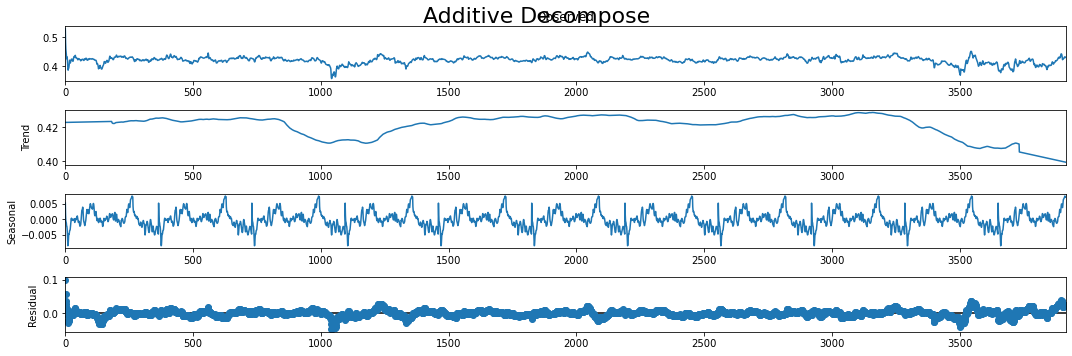

In [80]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(dataIn[:,3], model='a', extrapolate_trend='freq', period=365)
result_add.plot().suptitle('Additive Decompose', fontsize=22) 
r=[result_add.trend.std(),result_add.seasonal.mean(),result_add.resid.mean()]
sum(r),r

## s

In [13]:
split=0.2
trainx,vx,trainy,vy=train_test_split(dataIn,dataOut,test_size=split,shuffle=False)
traink,vk=trainy[:,lookAhead:],vy[:,lookAhead:]
trainy,vy=trainy[:,:lookAhead],vy[:,:lookAhead]
print("Total Samples:",len(dataIn),"\tTraining Samples:",len(trainx),"  Total Validation Samples:",len(vy))
print("Input Shape:",trainx.shape[1:],"\tOutput Shape:",trainy.shape[1:])

Total Samples: 12794 	Training Samples: 10235   Total Validation Samples: 2559
Input Shape: (10, 1) 	Output Shape: (5, 1)


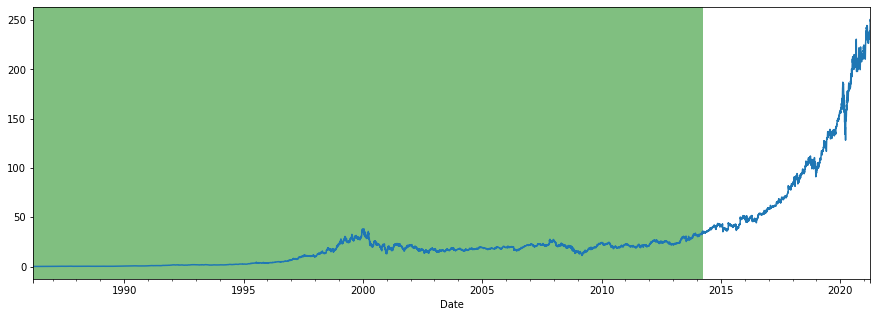

In [14]:
ax = data['Close'].plot()
f,f[len(trainx):],f[len(trainx)+len(vx):]=np.full((len(dataIn)), 1),2,3
ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),f[np.newaxis],cmap='ocean', alpha=0.5)
plt.show()#Green is the training data white is the validation data 

error MSE RMSE MAE MAPE

## Data Exploration

## Creating Performance Baselines 

In [50]:
columns=[s+"_t"+str(i) for s in ["Train","Val"] for i in range(lookAhead)]
columns.insert(0, "1-Shot")
columns.insert(0, "model")
benchmarker=pd.DataFrame(columns=columns)

repeat last input baseline

In [51]:
repeatLastTrain=np.array([np.full((5,1), v[-1]) for v in trainx])
repeatLastVal=np.array([np.full((5,1), v[-1]) for v in vx])

NameError: name 'trainx' is not defined

In [52]:
print(evaluatePredictions(trainy,repeatLastTrain))
print(evaluatePredictions(vy,repeatLastVal))

NameError: name 'evaluatePredictions' is not defined

In [143]:
benchmarker.loc[0]=0
benchmarker.loc[0]["model"]="RepeatBL"
benchmarker.loc[0]["1-Shot"]=np.nan
benchmarker.iloc[0,2:]=np.array([evaluatePredictions(trainy,repeatLastTrain),evaluatePredictions(vy,repeatLastVal)]).reshape(-1,order='C')

In [151]:
benchmarker

,model,1-Shot,Train_t0,Train_t1,Train_t2,Train_t3,Train_t4,Val_t0,Val_t1,Val_t2,Val_t3,Val_t4
0,RepeatBL,NaN,0.000053,0.000211,0.00047,0.000828,0.001284,0.000021,0.000081,0.000181,0.000317,0.000491


## Testing Different Models Performance

In [145]:
tf.keras.backend.clear_session()
singleshot=True
# callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=5)]
# lr_shedule=tf.keras.callbacks.LearningRateScheduler( lambda x: 1e-8*10**(x/20))

In [146]:
def compileFit(model, TrainingX=trainx, TrainingY=trainy,ValX=vx,ValY=vy,optimizer="adam",loss="mean_squared_error", patience=3,epochs=Epochs,shuffle=True,batch_size=75,singleshot=False):
    model.compile(loss=loss,optimizer=optimizer)
    if singleshot: return model.fit(TrainingX, TrainingY[:, 0],shuffle=shuffle, batch_size=batch_size,validation_data=(vx,vy[:, 0]),epochs=epochs,callbacks=EarlyStopping(monitor='val_loss', min_delta=0, patience=patience))  
    return model.fit(TrainingX, TrainingY,shuffle=shuffle, batch_size=batch_size,validation_data=(vx,vy),epochs=epochs,callbacks=EarlyStopping(monitor='val_loss', min_delta=0, patience=patience))

In [147]:
trainx.shape,trainy.shape

((10235, 10, 1), (10235, 5, 1))

### Simple-RNN

#### Finding Params

In [148]:
# tf.keras.backend.clear_session()
# def RNN_model(hp=None):
#     M = Sequential()
# #     hp_units = hp.Int('units', min_value=400, max_value=512, step=32)
#     hp_units=400  
#     M.add(Input(shape=trainx.shape[1:]))
#     M.add(LayerNormalization(axis=1))
#     M.add(SimpleRNN(hp_units, return_sequences=True))
#     M.add(LeakyReLU())
#     M.add(SimpleRNN(hp_units))
#     M.add(LeakyReLU())
#     M.add(Dense(1))
#     hp_learning_rate = hp.Choice('learning_rate', values=[0.01,0.001,0.0001,0.00001,0.000001])
# #     hp_learning_rate=0.000001
#     M.compile(loss="huber",optimizer=SGD(lr=hp_learning_rate, momentum=0.9),metrics=["mae"])
#     return M
# # model=RNN_model()
# # history=model.fit(trainx, trainy,shuffle=True, batch_size=75,validation_data=(vx,vy),epochs=1000,callbacks=EarlyStopping(monitor='val_loss', min_delta=0, patience=3))  
# tuner = kt.RandomSearch (RNN_model, objective='val_loss',
#                         executions_per_trial=1,
#                          overwrite=True,
#                       max_trials=100,directory='my_dir',
#                      project_name='RNN_model')
# tuner.search(trainx, trainy, epochs=1000, validation_data=(vx,vy),batch_size=75 ,callbacks=callbacks)

In [149]:
# best_hps=tuner.get_best_hyperparameters(num_trials=1)
# best=best_hps[0]
# # best.get('units'), 
# best.get('learning_rate')

#### Deploying the best model

In [86]:
tf.keras.backend.clear_session()
def RNN_model(activation='elu',hidden=16,singleshot=False):
    if singleshot: outputSize=1
    else: outputSize=lookAhead
    return Sequential([SimpleRNN(hidden,activation, return_sequences=True),
                       Dropout(0.2),
                       SimpleRNN(hidden,activation),
                       Dropout(0.2),
                       Dense(outputSize,activation),
                       Reshape([outputSize, 1])])
model = RNN_model("elu",50,singleshot)
history = compileFit(model,loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),epochs=400,shuffle=True,batch_size=500,patience=30,singleshot=singleshot)
model.summary()
# model.save("RNN_model")
# model=tf.keras.models.load_model('RNN_model')

Epoch 1/400
21/21 [==============================] - 2s 30ms/step - loss: 0.4661 - val_loss: 0.0044
Epoch 2/400
21/21 [==============================] - 0s 17ms/step - loss: 0.0230 - val_loss: 9.1906e-04
Epoch 3/400
21/21 [==============================] - 0s 19ms/step - loss: 0.0111 - val_loss: 2.8756e-04
Epoch 4/400
21/21 [==============================] - 0s 18ms/step - loss: 0.0078 - val_loss: 1.5071e-04
Epoch 5/400
21/21 [==============================] - 0s 18ms/step - loss: 0.0060 - val_loss: 1.1473e-04
Epoch 6/400
21/21 [==============================] - 0s 17ms/step - loss: 0.0052 - val_loss: 3.7424e-04
Epoch 7/400
21/21 [==============================] - 0s 18ms/step - loss: 0.0044 - val_loss: 2.0713e-04
Epoch 8/400
21/21 [==============================] - 0s 18ms/step - loss: 0.0039 - val_loss: 3.3505e-04
Epoch 9/400
21/21 [==============================] - 0s 18ms/step - loss: 0.0034 - val_loss: 2.2316e-04
Epoch 10/400
21/21 [==============================] - 0s 19ms/step -

Epoch 152/400
21/21 [==============================] - 0s 18ms/step - loss: 1.3569e-04 - val_loss: 4.9080e-05
Epoch 153/400
21/21 [==============================] - 0s 17ms/step - loss: 1.4154e-04 - val_loss: 3.7951e-05
Epoch 154/400
21/21 [==============================] - 0s 18ms/step - loss: 1.3292e-04 - val_loss: 5.0873e-05
Epoch 155/400
21/21 [==============================] - 0s 18ms/step - loss: 1.3500e-04 - val_loss: 5.2724e-05
Epoch 156/400
21/21 [==============================] - 0s 19ms/step - loss: 1.3461e-04 - val_loss: 4.6946e-05
Epoch 157/400
21/21 [==============================] - 0s 18ms/step - loss: 1.3413e-04 - val_loss: 3.6637e-05
Epoch 158/400
21/21 [==============================] - 0s 18ms/step - loss: 1.3965e-04 - val_loss: 4.0341e-05
Epoch 159/400
21/21 [==============================] - 0s 18ms/step - loss: 1.3691e-04 - val_loss: 3.9267e-05
Epoch 160/400
21/21 [==============================] - 0s 18ms/step - loss: 1.3594e-04 - val_loss: 3.6706e-05
Epoch 161/

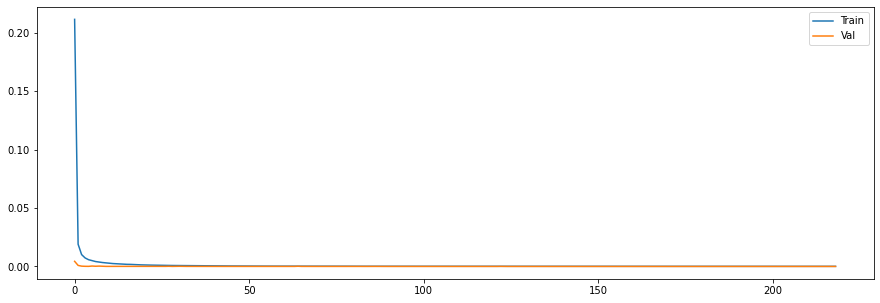

In [87]:
plotCompare(history.history['loss'],history.history['val_loss'],["Train","Val"])

In [88]:
if singleshot: 
    predictionsT=StepForwardPredictions(trainx,model,lookAhead)
    predictions=StepForwardPredictions(vx,model,lookAhead)
else: 
    predictionsT=model.predict(trainx)
    predictions=model.predict(vx)
benchmarker.loc[benchmarker.index.max()+1]=0
benchmarker.loc[benchmarker.index.max()]["model"]="RNN"
benchmarker.loc[benchmarker.index.max()]["1-Shot"]=singleshot
benchmarker.iloc[benchmarker.index.max(),2:]=np.array([evaluatePredictions(trainy,predictionsT),evaluatePredictions(vy,predictions)]).reshape(-1,order='C')

In [89]:
df1=pd.DataFrame(reverseOutputTransform(predictions,vk,logged=False,scaled=True).reshape(-1,lookAhead))
df2=pd.DataFrame(reverseOutputTransform(vy,vk,logged=False,scaled=True).reshape(-1,lookAhead))

In [90]:
fromN,toN=60,70

<AxesSubplot:>

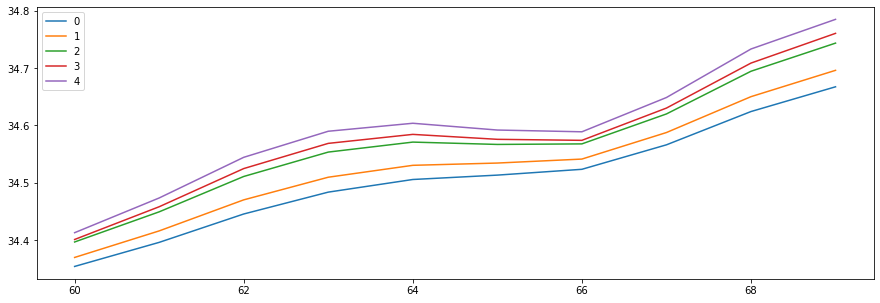

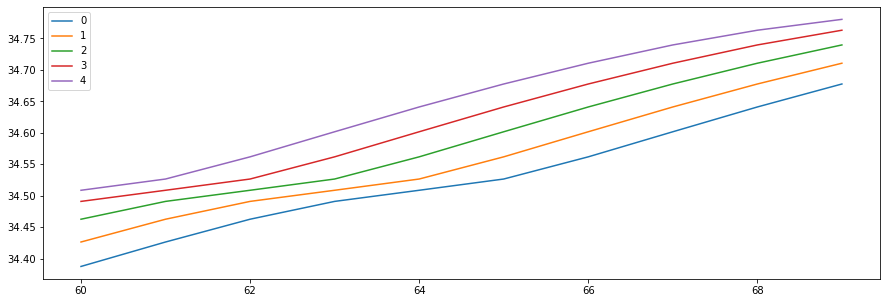

In [91]:
df1.iloc[fromN:toN].plot()
df2.iloc[fromN:toN].plot()

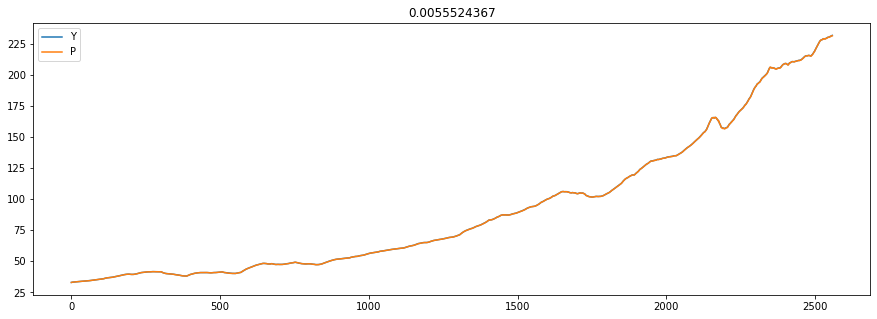

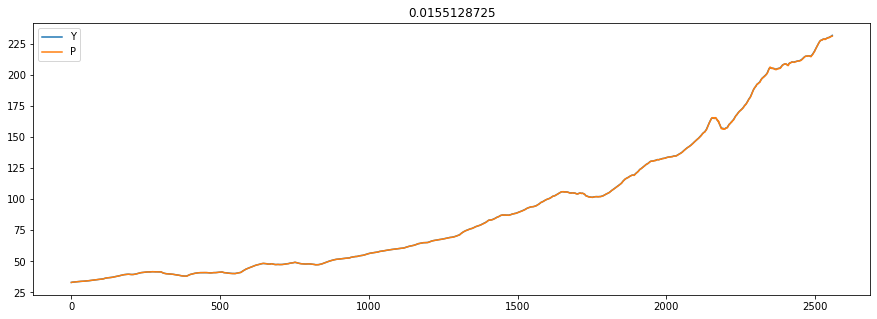

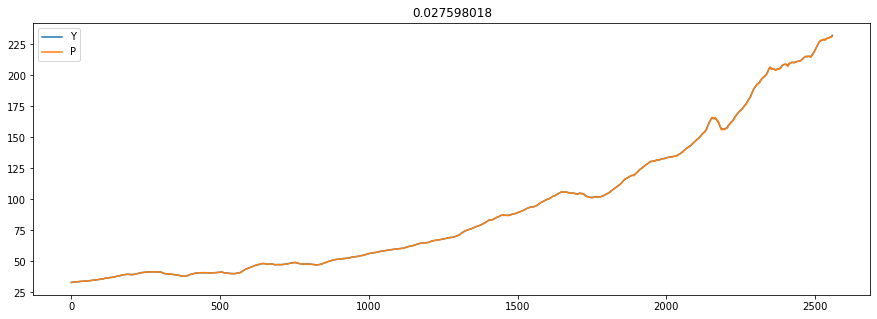

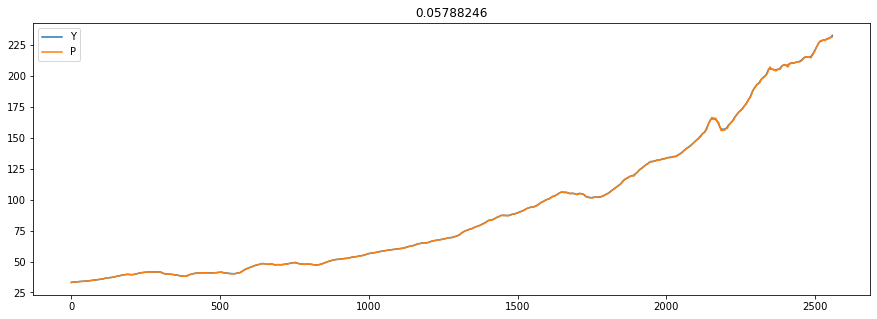

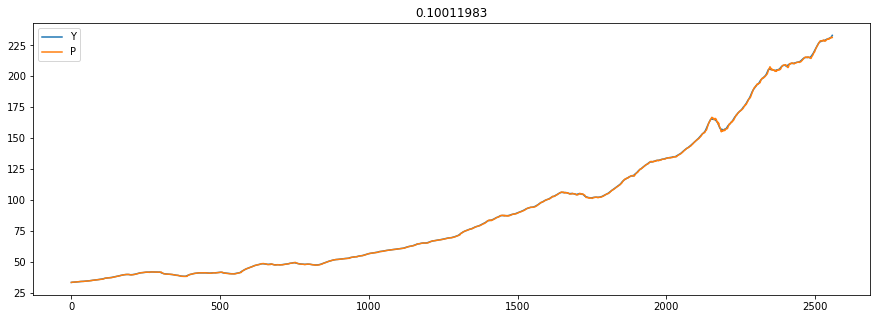

Shape  : (2559, 5, 1)
loss   : 11444.93359375
MSE    : 0.03401793028455823 
RMSE   : 0.1844395030479052 
NMSE   : 0.0009214808319977137 
DS     : 0.864659890539484 
WDS    : 0.004319939612515807 
Samples: 2559


In [92]:
plotAndEvaluate(reverseOutputTransform(vy,vk,logged=False,scaled=True),reverseOutputTransform(predictions,vk,logged=False,scaled=True))

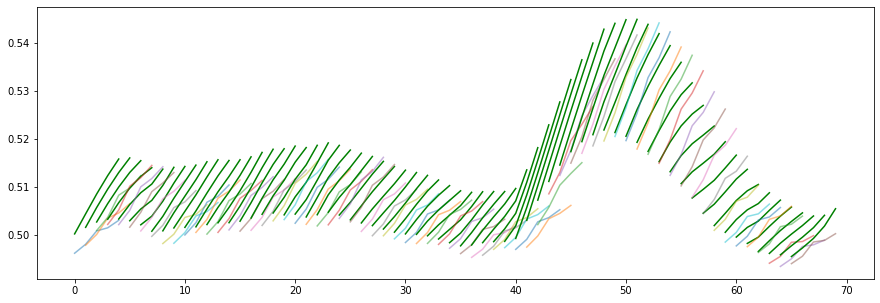

In [93]:
rrr=66
shiftff=66
plotMultVariate(vy[rrr:rrr+shiftff],predictions[rrr:rrr+shiftff],5)
# plotVisual(vy,predictions,lookAhead,0.001)

### LSTM

In [94]:
tf.keras.backend.clear_session()
def LSTM_model(activation='elu',hidden=16,singleshot=False):
    if singleshot: outputSize=1
    else: outputSize=lookAhead
    return Sequential([LSTM(hidden,activation,return_sequences=True),
                       Dropout(0.5),
                       LSTM(hidden,activation,return_sequences=True),
                       Dropout(0.5),
                       LSTM(hidden,activation),
                       Dense(outputSize,"linear"),
                       Reshape([outputSize, 1])])
model=LSTM_model('elu',100,singleshot)
history=compileFit(model,loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),epochs=400,shuffle=True,batch_size=1000,patience=30,singleshot=singleshot)
model.summary()
# model.save("BILSTM_model")
# model=tf.keras.models.load_model('BILSTM_model')

Epoch 1/400
11/11 [==============================] - 4s 114ms/step - loss: 2.1579 - val_loss: 0.1382
Epoch 2/400
11/11 [==============================] - 1s 58ms/step - loss: 0.0732 - val_loss: 0.0288
Epoch 3/400
11/11 [==============================] - 1s 62ms/step - loss: 0.0170 - val_loss: 0.0070
Epoch 4/400
11/11 [==============================] - 1s 56ms/step - loss: 0.0072 - val_loss: 0.0014
Epoch 5/400
11/11 [==============================] - 1s 60ms/step - loss: 0.0039 - val_loss: 9.6000e-04
Epoch 6/400
11/11 [==============================] - 1s 61ms/step - loss: 0.0032 - val_loss: 6.6350e-04
Epoch 7/400
11/11 [==============================] - 1s 64ms/step - loss: 0.0029 - val_loss: 7.2250e-04
Epoch 8/400
11/11 [==============================] - 1s 59ms/step - loss: 0.0028 - val_loss: 7.0752e-04
Epoch 9/400
11/11 [==============================] - 1s 58ms/step - loss: 0.0028 - val_loss: 6.6579e-04
Epoch 10/400
11/11 [==============================] - 1s 58ms/step - loss: 0.00

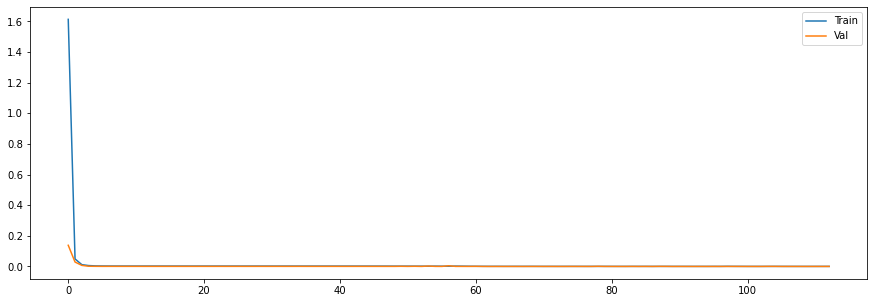

In [95]:
plotCompare(history.history['loss'],history.history['val_loss'],["Train","Val"])

In [96]:
if singleshot: 
    predictionsT=StepForwardPredictions(trainx,model,lookAhead)
    predictions=StepForwardPredictions(vx,model,lookAhead)
else: 
    predictionsT=model.predict(trainx)
    predictions=model.predict(vx)
benchmarker.loc[benchmarker.index.max()+1]=0
benchmarker.loc[benchmarker.index.max()]["model"]="RESLSTM"
benchmarker.loc[benchmarker.index.max()]["1-Shot"]=singleshot
benchmarker.iloc[benchmarker.index.max(),2:]=np.array([evaluatePredictions(trainy,predictionsT),evaluatePredictions(vy,predictions)]).reshape(-1,order='C')

In [97]:
df1=pd.DataFrame(reverseOutputTransform(predictions,vk,logged=False,scaled=True).reshape(-1,lookAhead))
df2=pd.DataFrame(reverseOutputTransform(vy,vk,logged=False,scaled=True).reshape(-1,lookAhead))

In [98]:
fromN,toN=60,70

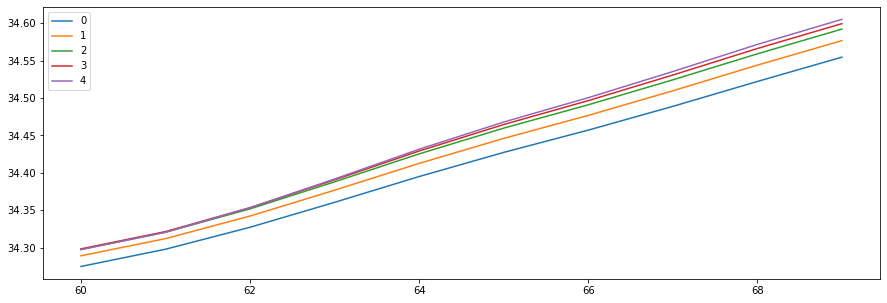

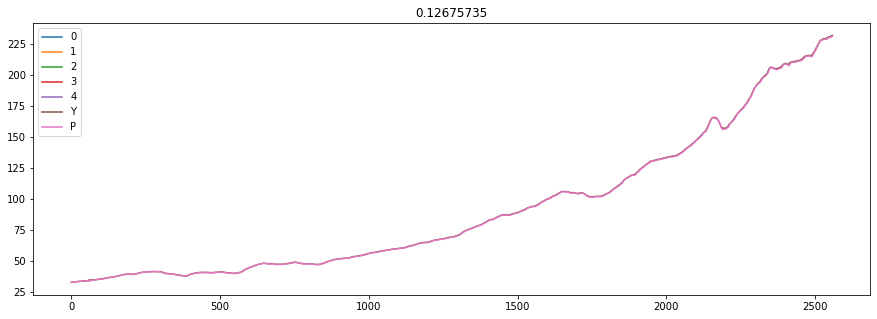

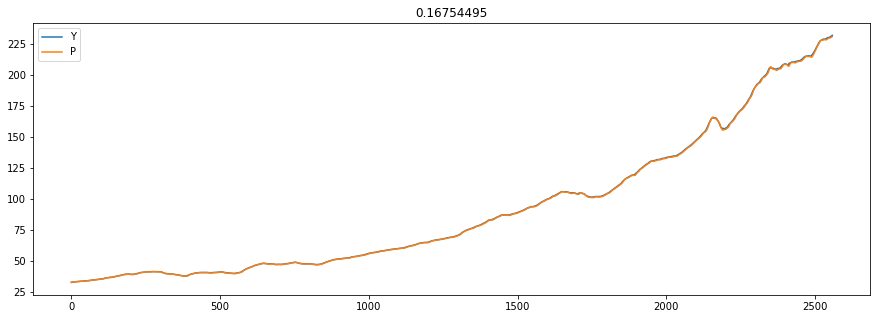

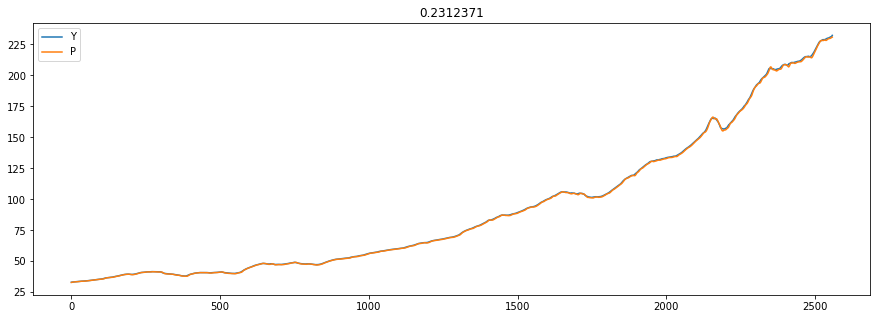

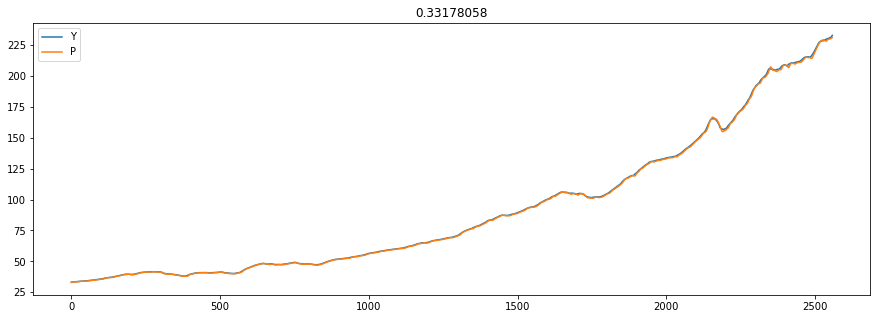

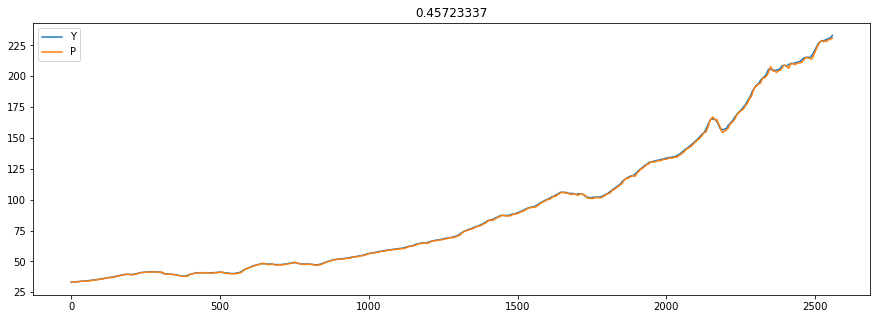

Shape  : (2559, 5, 1)
loss   : 11446.9521484375
MSE    : 0.24968385532716045 
RMSE   : 0.4996837553164606 
NMSE   : 0.0024964771373579327 
DS     : 0.880766223612197 
WDS    : 0.004400408692918942 
Samples: 2559


In [99]:
df1.iloc[fromN:toN].plot()
df2.iloc[fromN:toN].plot()
plotAndEvaluate(reverseOutputTransform(vy,vk,logged=False,scaled=True),reverseOutputTransform(predictions,vk,logged=False,scaled=True))

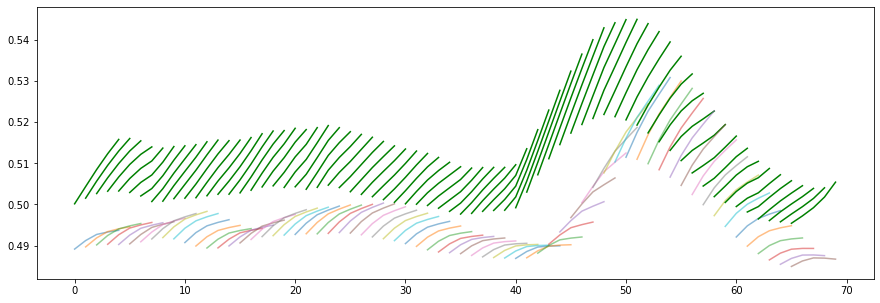

In [100]:
rrr=66
shiftff=66
plotMultVariate(vy[rrr:rrr+shiftff],predictions[rrr:rrr+shiftff],5)
# plotVisual(vy,predictions,lookAhead,0.001)

### RESLSTM

In [101]:
def RESLSTM(shape, activation='elu',hidden=32,singleshot=False):
    if singleshot: outputSize=1
    else: outputSize=lookAhead
    x = Input(shape=shape)
    y = LSTM(hidden,activation, return_sequences=True)(x)
    D = Dropout(0.5)(y)
    D = LSTM(hidden,activation, return_sequences=False)(D)
    D = Dropout(0.5)(y)
    D = Dense(period, activation)(y)
    D = Add()([x, D])
    D = Flatten()(D)
    D = Dense(outputSize)(D)
    out = Reshape([outputSize, 1])(D)
    return tf.keras.models.Model(inputs=x, outputs=out)
model = RESLSTM((period,1),'elu',100,singleshot)
history=compileFit(model,loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),epochs=400,shuffle=True,batch_size=500,patience=30,singleshot=singleshot)
model.summary()
# model.save("RESLSTM")
# model=tf.keras.models.load_model('RESLSTM')
# tf.keras.utils.plot_model(model)

Epoch 1/400
21/21 [==============================] - 2s 32ms/step - loss: 0.1202 - val_loss: 0.0031
Epoch 2/400
21/21 [==============================] - 0s 22ms/step - loss: 0.0031 - val_loss: 8.1032e-04
Epoch 3/400
21/21 [==============================] - 0s 22ms/step - loss: 0.0013 - val_loss: 3.0105e-04
Epoch 4/400
21/21 [==============================] - 0s 21ms/step - loss: 7.8752e-04 - val_loss: 1.7821e-04
Epoch 5/400
21/21 [==============================] - 0s 22ms/step - loss: 5.3602e-04 - val_loss: 1.2499e-04
Epoch 6/400
21/21 [==============================] - 0s 23ms/step - loss: 3.7771e-04 - val_loss: 1.3768e-04
Epoch 7/400
21/21 [==============================] - 0s 22ms/step - loss: 3.6691e-04 - val_loss: 2.9395e-04
Epoch 8/400
21/21 [==============================] - 0s 22ms/step - loss: 3.1567e-04 - val_loss: 2.1296e-04
Epoch 9/400
21/21 [==============================] - 0s 22ms/step - loss: 3.5372e-04 - val_loss: 1.2371e-04
Epoch 10/400
21/21 [========================

Epoch 148/400
21/21 [==============================] - 0s 21ms/step - loss: 9.2984e-05 - val_loss: 3.8229e-05
Epoch 149/400
21/21 [==============================] - 0s 21ms/step - loss: 9.1430e-05 - val_loss: 4.1655e-05
Epoch 150/400
21/21 [==============================] - 0s 22ms/step - loss: 9.8973e-05 - val_loss: 5.8281e-05
Epoch 151/400
21/21 [==============================] - 0s 22ms/step - loss: 9.4499e-05 - val_loss: 4.8152e-05
Epoch 152/400
21/21 [==============================] - 0s 21ms/step - loss: 1.0384e-04 - val_loss: 4.3819e-05
Epoch 153/400
21/21 [==============================] - 0s 21ms/step - loss: 1.9514e-04 - val_loss: 8.0663e-05
Epoch 154/400
21/21 [==============================] - 0s 22ms/step - loss: 1.0773e-04 - val_loss: 3.9649e-05
Epoch 155/400
21/21 [==============================] - 0s 22ms/step - loss: 9.6120e-05 - val_loss: 4.3265e-05
Epoch 156/400
21/21 [==============================] - 0s 22ms/step - loss: 9.5212e-05 - val_loss: 3.6804e-05
Epoch 157/

21/21 [==============================] - 0s 22ms/step - loss: 7.7524e-05 - val_loss: 3.6050e-05
Epoch 297/400
21/21 [==============================] - 0s 21ms/step - loss: 7.9081e-05 - val_loss: 3.1663e-05
Epoch 298/400
21/21 [==============================] - 0s 22ms/step - loss: 6.9688e-05 - val_loss: 3.2028e-05
Epoch 299/400
21/21 [==============================] - 0s 22ms/step - loss: 7.3980e-05 - val_loss: 3.8009e-05
Epoch 300/400
21/21 [==============================] - 0s 22ms/step - loss: 7.3016e-05 - val_loss: 5.8021e-05
Epoch 301/400
21/21 [==============================] - 0s 23ms/step - loss: 8.0909e-05 - val_loss: 2.9396e-05
Epoch 302/400
21/21 [==============================] - 0s 22ms/step - loss: 7.0942e-05 - val_loss: 3.3357e-05
Epoch 303/400
21/21 [==============================] - 0s 23ms/step - loss: 7.2228e-05 - val_loss: 3.8479e-05
Epoch 304/400
21/21 [==============================] - 0s 21ms/step - loss: 7.9227e-05 - val_loss: 4.3049e-05
Epoch 305/400
21/21 [===

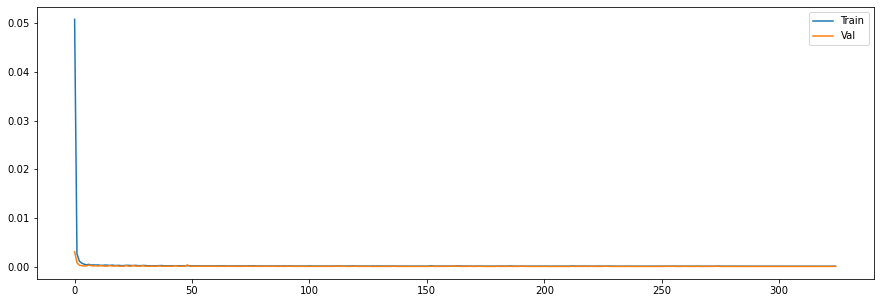

In [102]:
plotCompare(history.history['loss'],history.history['val_loss'],["Train","Val"])

In [103]:
if singleshot: 
    predictionsT=StepForwardPredictions(trainx,model,lookAhead)
    predictions=StepForwardPredictions(vx,model,lookAhead)
else: 
    predictionsT=model.predict(trainx)
    predictions=model.predict(vx)
benchmarker.loc[benchmarker.index.max()+1]=0
benchmarker.loc[benchmarker.index.max()]["model"]="RESLSTM"
benchmarker.loc[benchmarker.index.max()]["1-Shot"]=singleshot
benchmarker.iloc[benchmarker.index.max(),2:]=np.array([evaluatePredictions(trainy,predictionsT),evaluatePredictions(vy,predictions)]).reshape(-1,order='C')

In [104]:
df1=pd.DataFrame(reverseOutputTransform(predictions,vk,logged=False,scaled=True).reshape(-1,lookAhead))
df2=pd.DataFrame(reverseOutputTransform(vy,vk,logged=False,scaled=True).reshape(-1,lookAhead))

In [105]:
fromN,toN=60,70

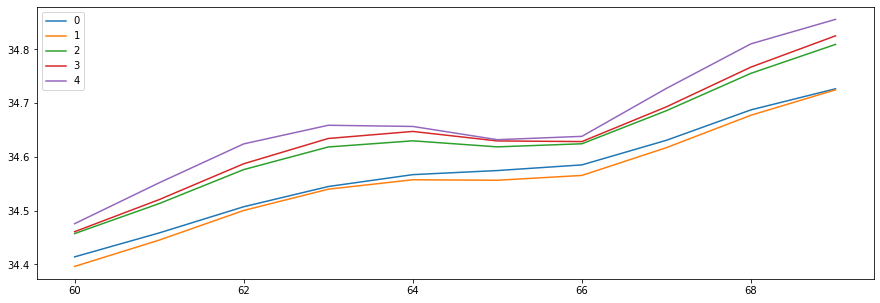

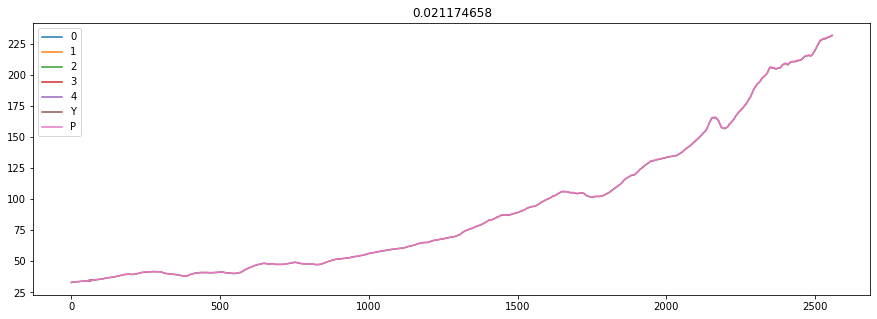

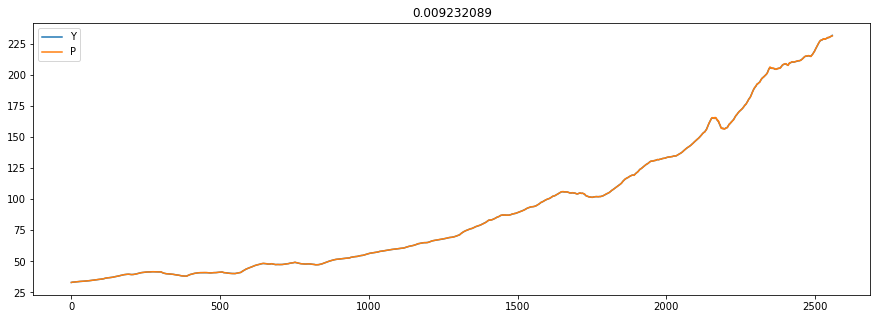

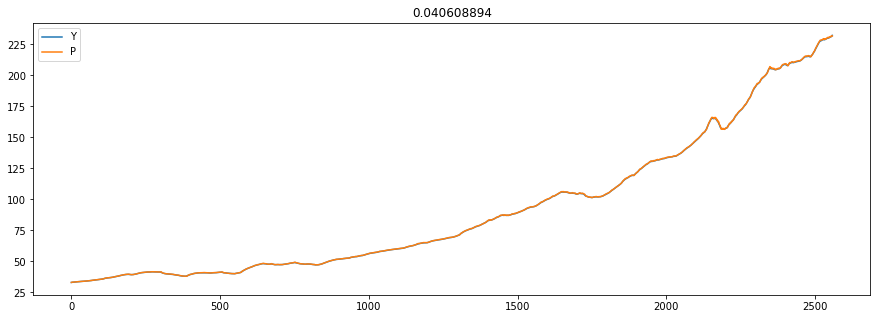

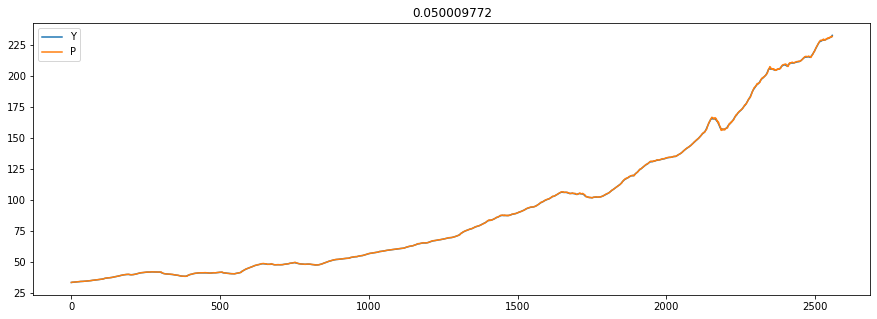

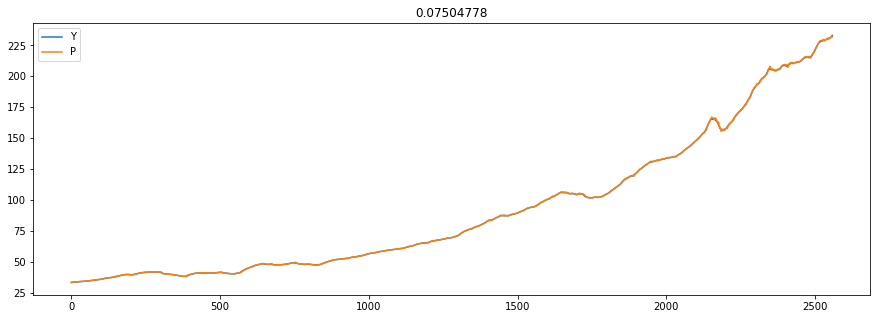

Shape  : (2559, 5, 1)
loss   : 11443.9228515625
MSE    : 0.03539610530639058 
RMSE   : 0.1881385269060821 
NMSE   : 0.0009399615778579262 
DS     : 0.8563721657544957 
WDS    : 0.0042785331925025444 
Samples: 2559


In [106]:
df1.iloc[fromN:toN].plot()
df2.iloc[fromN:toN].plot()
plotAndEvaluate(reverseOutputTransform(vy,vk,logged=False,scaled=True),reverseOutputTransform(predictions,vk,logged=False,scaled=True))

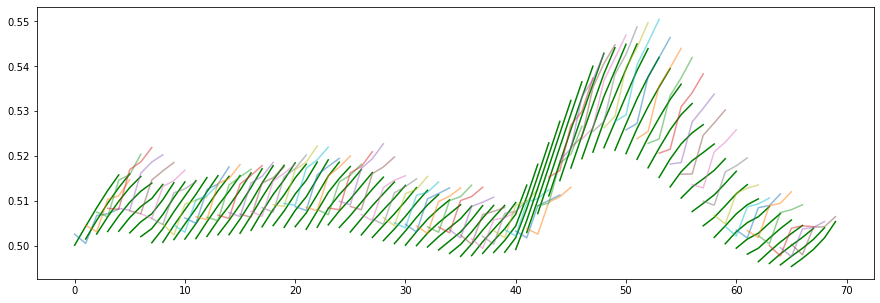

In [107]:
rrr=66
shiftff=66
plotMultVariate(vy[rrr:rrr+shiftff],predictions[rrr:rrr+shiftff],5)
# plotVisual(vy,predictions,lookAhead,0.001)

### BILSTM

In [108]:
tf.keras.backend.clear_session()
def BILSTM_model(activation='elu',hidden=32,singleshot=False):
    if singleshot: outputSize=1
    else: outputSize=lookAhead
    return Sequential([Bidirectional(LSTM(hidden,activation,return_sequences=True)),
                       Dropout(0.5),
                       Bidirectional(LSTM(hidden, activation)),
                       Dropout(0.5),
                       Dense(outputSize,"linear"),
                       Reshape([outputSize, 1])])
model=BILSTM_model('elu',100,singleshot)
history=compileFit(model,loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),shuffle=True,batch_size=500,patience=20,singleshot=singleshot)
model.summary()
# model.save("BILSTM_model")
# model=tf.keras.models.load_model('BILSTM_model')


Epoch 1/100
21/21 [==============================] - 6s 102ms/step - loss: 0.0729 - val_loss: 6.6816e-04
Epoch 2/100
21/21 [==============================] - 1s 69ms/step - loss: 0.0057 - val_loss: 6.1224e-04
Epoch 3/100
21/21 [==============================] - 2s 73ms/step - loss: 0.0045 - val_loss: 8.7516e-04
Epoch 4/100
21/21 [==============================] - 2s 73ms/step - loss: 0.0038 - val_loss: 4.5038e-04
Epoch 5/100
21/21 [==============================] - 2s 80ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 6/100
21/21 [==============================] - 1s 69ms/step - loss: 0.0029 - val_loss: 1.8128e-04
Epoch 7/100
21/21 [==============================] - 2s 73ms/step - loss: 0.0018 - val_loss: 6.2707e-04
Epoch 8/100
21/21 [==============================] - 1s 72ms/step - loss: 0.0016 - val_loss: 8.1079e-05
Epoch 9/100
21/21 [==============================] - 1s 71ms/step - loss: 0.0012 - val_loss: 8.5781e-05
Epoch 10/100
21/21 [==============================] - 1s 69ms/step 

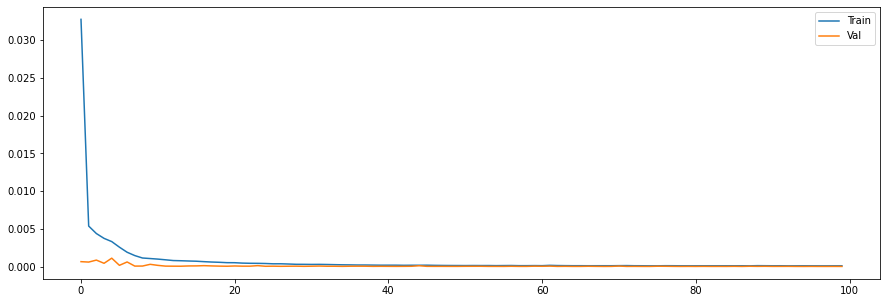

In [109]:
plotCompare(history.history['loss'],history.history['val_loss'],["Train","Val"])

In [110]:
if singleshot: 
    predictionsT=StepForwardPredictions(trainx,model,lookAhead)
    predictions=StepForwardPredictions(vx,model,lookAhead)
else: 
    predictionsT=model.predict(trainx)
    predictions=model.predict(vx)
benchmarker.loc[benchmarker.index.max()+1]=0
benchmarker.loc[benchmarker.index.max()]["model"]="BILSTM"
benchmarker.loc[benchmarker.index.max()]["1-Shot"]=singleshot
benchmarker.iloc[benchmarker.index.max(),2:]=np.array([evaluatePredictions(trainy,predictionsT),evaluatePredictions(vy,predictions)]).reshape(-1,order='C')

In [111]:
df1=pd.DataFrame(reverseOutputTransform(predictions,vk,logged=False,scaled=True).reshape(-1,lookAhead))
df2=pd.DataFrame(reverseOutputTransform(vy,vk,logged=False,scaled=True).reshape(-1,lookAhead))

In [112]:
fromN,toN=60,70

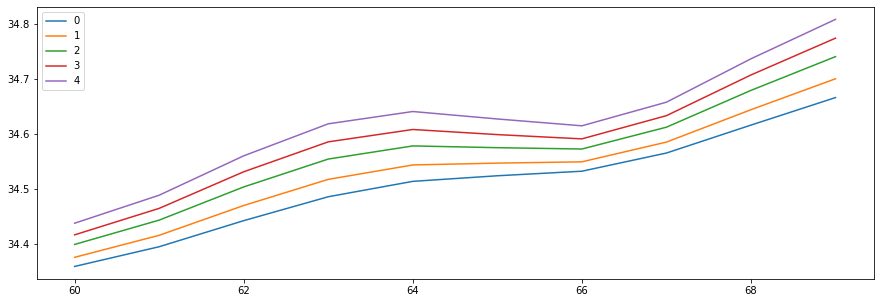

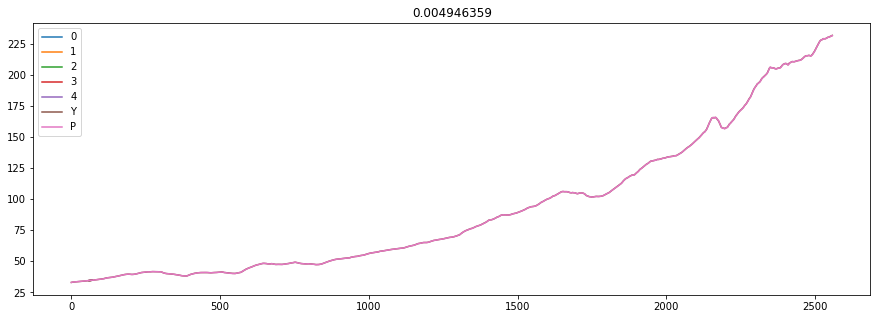

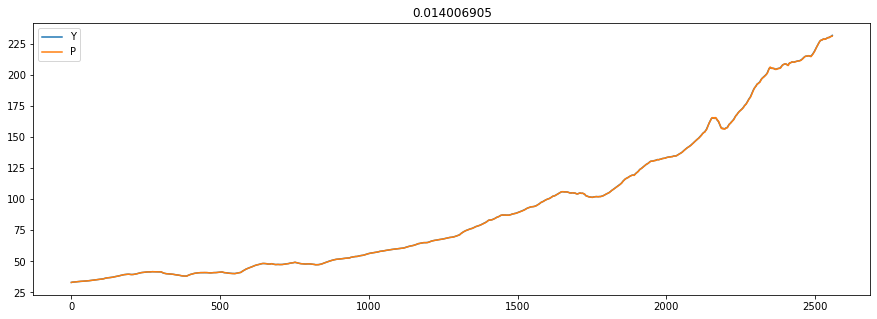

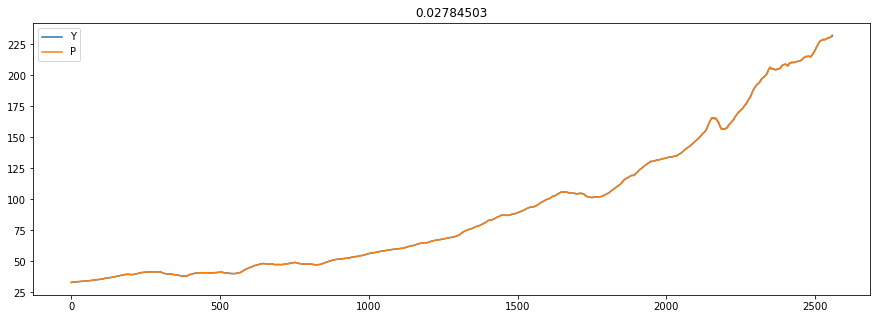

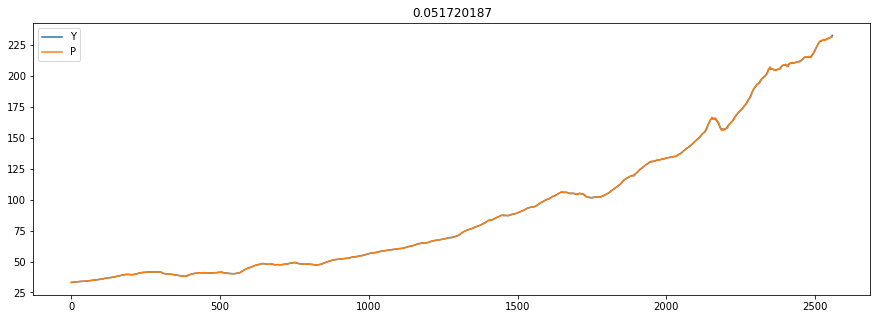

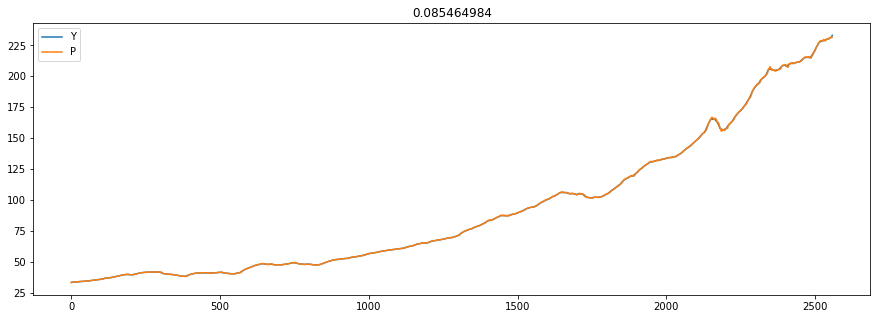

Shape  : (2559, 5, 1)
loss   : 11444.7412109375
MSE    : 0.030647054335259077 
RMSE   : 0.17506300104607792 
NMSE   : 0.0008746347566012306 
DS     : 0.8702111024237685 
WDS    : 0.004347674101392616 
Samples: 2559


In [113]:
df1.iloc[fromN:toN].plot()
df2.iloc[fromN:toN].plot()
plotAndEvaluate(reverseOutputTransform(vy,vk,logged=False,scaled=True),reverseOutputTransform(predictions,vk,logged=False,scaled=True))

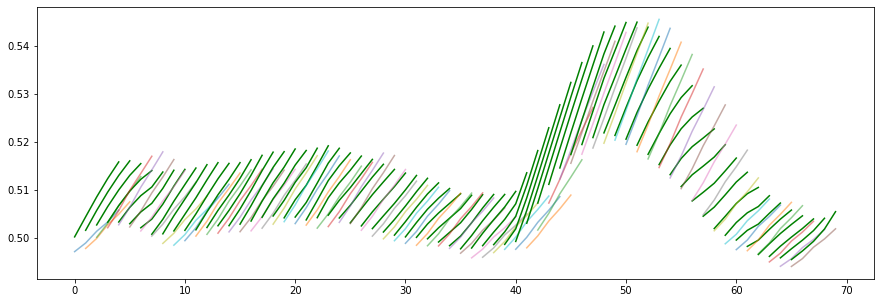

In [114]:
rrr=66
shiftff=66
plotMultVariate(vy[rrr:rrr+shiftff],predictions[rrr:rrr+shiftff],5)
# plotVisual(vy,predictions,lookAhead,0.001)

### ConvLSTM

In [115]:
tf.keras.backend.clear_session()
def CovLSTM_model(activation='elu', hidden=32, singleshot=False):
    if singleshot: outputSize = 1
    else: outputSize = lookAhead
    return Sequential([Conv1D(filters=64,kernel_size=lookAhead,strides=1,padding="causal",activation=activation),
                       LSTM(hidden, activation, return_sequences=False),
                       Dropout(0.5),
                       Dense(outputSize, activation),
                       Reshape([outputSize, 1])])
model = CovLSTM_model('elu', 100, singleshot)
history = compileFit(model,
                     loss='mse',
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     shuffle=True,
                     batch_size=500,
                     patience=30,
                     singleshot=singleshot)
# model.save("CovLSTM_model")
# model=tf.keras.models.load_model('CovLSTM_model')

Epoch 1/100
21/21 [==============================] - 2s 32ms/step - loss: 0.1108 - val_loss: 0.0114
Epoch 2/100
21/21 [==============================] - 0s 23ms/step - loss: 0.0169 - val_loss: 0.0025
Epoch 3/100
21/21 [==============================] - 0s 22ms/step - loss: 0.0119 - val_loss: 0.0013
Epoch 4/100
21/21 [==============================] - 0s 23ms/step - loss: 0.0103 - val_loss: 9.2332e-04
Epoch 5/100
21/21 [==============================] - 0s 22ms/step - loss: 0.0096 - val_loss: 9.6331e-04
Epoch 6/100
21/21 [==============================] - 0s 21ms/step - loss: 0.0090 - val_loss: 7.6292e-04
Epoch 7/100
21/21 [==============================] - 0s 23ms/step - loss: 0.0084 - val_loss: 7.1609e-04
Epoch 8/100
21/21 [==============================] - 0s 22ms/step - loss: 0.0078 - val_loss: 6.0727e-04
Epoch 9/100
21/21 [==============================] - 0s 23ms/step - loss: 0.0076 - val_loss: 8.4313e-04
Epoch 10/100
21/21 [==============================] - 0s 21ms/step - loss: 0

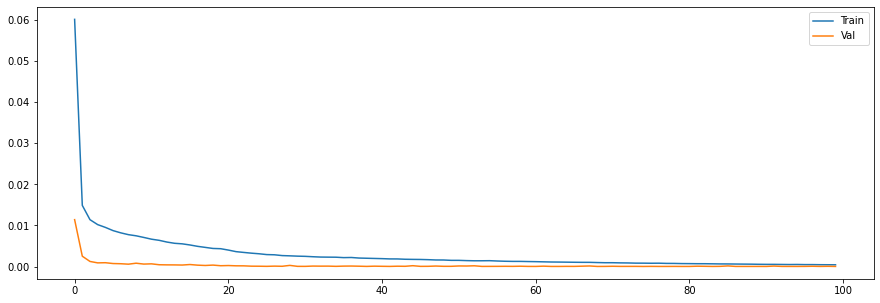

In [116]:
plotCompare(history.history['loss'],history.history['val_loss'],["Train","Val"])

In [117]:
if singleshot: 
    predictionsT=StepForwardPredictions(trainx,model,lookAhead)
    predictions=StepForwardPredictions(vx,model,lookAhead)
else: 
    predictionsT=model.predict(trainx)
    predictions=model.predict(vx)
benchmarker.loc[benchmarker.index.max()+1]=0
benchmarker.loc[benchmarker.index.max()]["model"]="CONVLSTM"
benchmarker.loc[benchmarker.index.max()]["1-Shot"]=singleshot
benchmarker.iloc[benchmarker.index.max(),2:]=np.array([evaluatePredictions(trainy,predictionsT),evaluatePredictions(vy,predictions)]).reshape(-1,order='C')

In [118]:
df1=pd.DataFrame(reverseOutputTransform(predictions,vk,logged=False,scaled=True).reshape(-1,lookAhead))
df2=pd.DataFrame(reverseOutputTransform(vy,vk,logged=False,scaled=True).reshape(-1,lookAhead))

In [119]:
fromN,toN=60,70

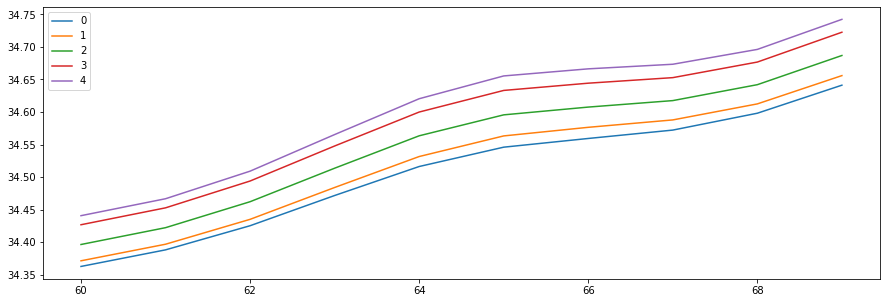

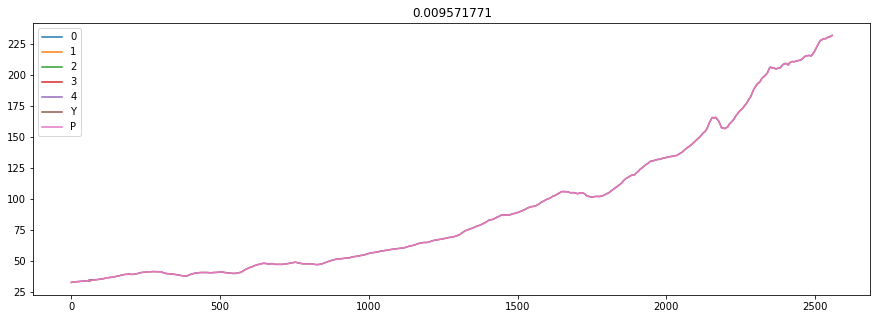

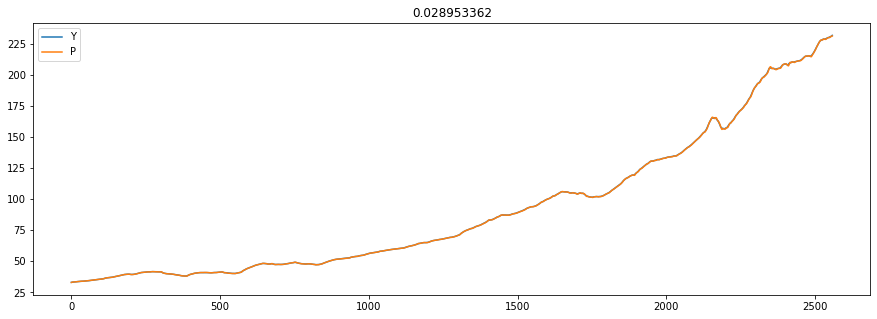

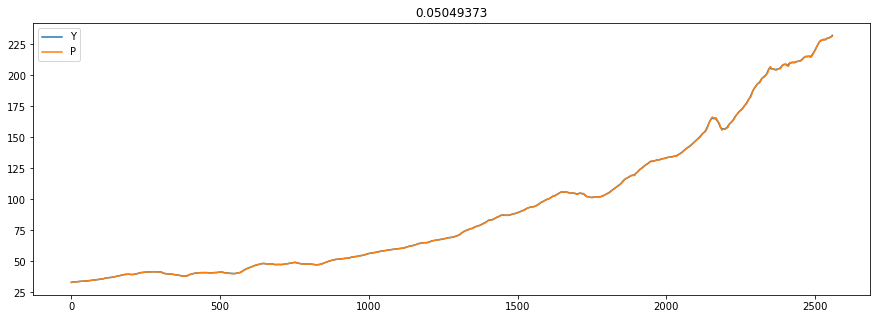

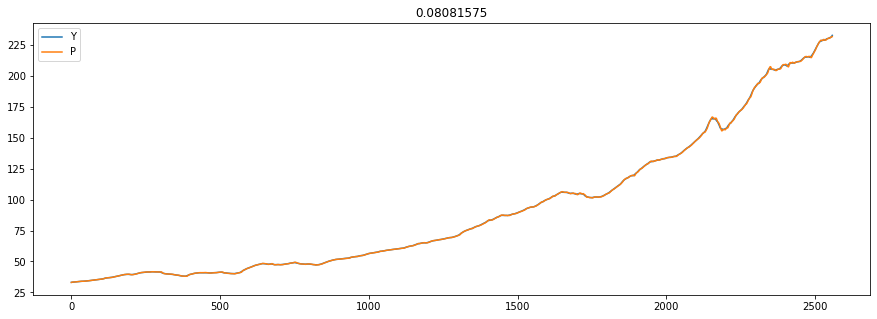

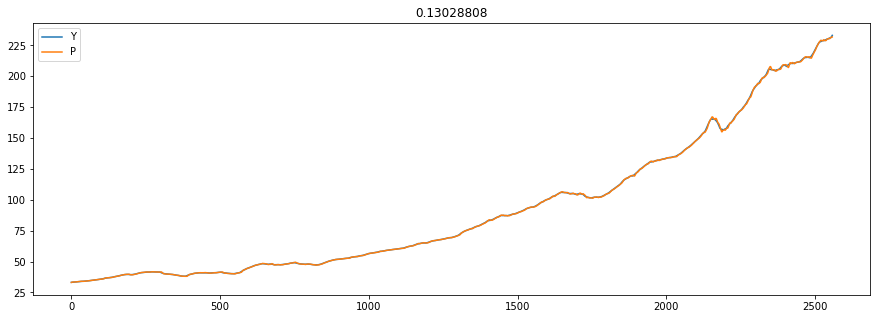

Shape  : (2559, 5, 1)
loss   : 11444.849609375
MSE    : 0.05179599942920876 
RMSE   : 0.22758734461566346 
NMSE   : 0.001137052378709355 
DS     : 0.8676309616888194 
WDS    : 0.004334783423463958 
Samples: 2559


In [120]:
df1.iloc[fromN:toN].plot()
df2.iloc[fromN:toN].plot()
plotAndEvaluate(reverseOutputTransform(vy,vk,logged=False,scaled=True),reverseOutputTransform(predictions,vk,logged=False,scaled=True))

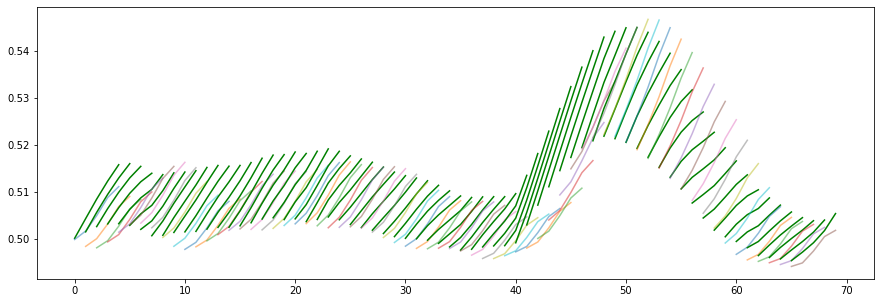

In [121]:
rrr=66
shiftff=66
plotMultVariate(vy[rrr:rrr+shiftff],predictions[rrr:rrr+shiftff],5)
# plotVisual(vy,predictions,lookAhead,0.001)

### DNN

In [122]:
tf.keras.backend.clear_session()
def DNN_model(activation='elu',hidden=512,singleshot=False,dropout=0.5):
    if singleshot: outputSize=1
    else: outputSize=lookAhead
    return Sequential([Dense(hidden, activation),
                        Dropout(dropout),
                        Dense(hidden, activation),
                        Dropout(dropout),
                        Dense(1, activation),
                        Flatten(),
                        Dense(outputSize),
                        Reshape([outputSize,1])])
model=DNN_model("elu",512,singleshot,0.5)
history=compileFit(model,loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),epochs=10000,batch_size=500,patience=30,singleshot=singleshot)
# model.save("DNN_model")
# model=tf.keras.models.load_model('DNN_model')
# model.summary()

Epoch 1/10000
21/21 [==============================] - 1s 18ms/step - loss: 2.3682 - val_loss: 0.1814
Epoch 2/10000
21/21 [==============================] - 0s 9ms/step - loss: 0.1722 - val_loss: 0.0929
Epoch 3/10000
21/21 [==============================] - 0s 9ms/step - loss: 0.0804 - val_loss: 0.0451
Epoch 4/10000
21/21 [==============================] - 0s 9ms/step - loss: 0.0411 - val_loss: 0.0243
Epoch 5/10000
21/21 [==============================] - 0s 9ms/step - loss: 0.0229 - val_loss: 0.0129
Epoch 6/10000
21/21 [==============================] - 0s 9ms/step - loss: 0.0130 - val_loss: 0.0067
Epoch 7/10000
21/21 [==============================] - 0s 9ms/step - loss: 0.0078 - val_loss: 0.0034
Epoch 8/10000
21/21 [==============================] - 0s 9ms/step - loss: 0.0050 - val_loss: 0.0019
Epoch 9/10000
21/21 [==============================] - 0s 9ms/step - loss: 0.0038 - val_loss: 0.0011
Epoch 10/10000
21/21 [==============================] - 0s 9ms/step - loss: 0.0031 - val_l

21/21 [==============================] - 0s 9ms/step - loss: 4.2188e-04 - val_loss: 1.1332e-04
Epoch 154/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.0275e-04 - val_loss: 1.1243e-04
Epoch 155/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.8825e-04 - val_loss: 1.1258e-04
Epoch 156/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.0389e-04 - val_loss: 1.1261e-04
Epoch 157/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.8812e-04 - val_loss: 1.1122e-04
Epoch 158/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.8561e-04 - val_loss: 1.1914e-04
Epoch 159/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.9494e-04 - val_loss: 1.0962e-04
Epoch 160/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.7843e-04 - val_loss: 1.0872e-04
Epoch 161/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.7077e-04 - val_loss: 1.1183e-04
Epoch 162/10000
2

Epoch 227/10000
21/21 [==============================] - 0s 9ms/step - loss: 2.5448e-04 - val_loss: 8.8639e-05
Epoch 228/10000
21/21 [==============================] - 0s 9ms/step - loss: 2.6024e-04 - val_loss: 8.5699e-05
Epoch 229/10000
21/21 [==============================] - 0s 9ms/step - loss: 2.5758e-04 - val_loss: 8.6660e-05
Epoch 230/10000
21/21 [==============================] - 0s 9ms/step - loss: 2.5359e-04 - val_loss: 8.5322e-05
Epoch 231/10000
21/21 [==============================] - 0s 9ms/step - loss: 2.6583e-04 - val_loss: 8.4959e-05
Epoch 232/10000
21/21 [==============================] - 0s 9ms/step - loss: 2.4978e-04 - val_loss: 8.4775e-05
Epoch 233/10000
21/21 [==============================] - 0s 9ms/step - loss: 2.4084e-04 - val_loss: 8.6544e-05
Epoch 234/10000
21/21 [==============================] - 0s 9ms/step - loss: 2.4240e-04 - val_loss: 8.4716e-05
Epoch 235/10000
21/21 [==============================] - 0s 9ms/step - loss: 2.5376e-04 - val_loss: 8.4415e-05
E

Epoch 301/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.9670e-04 - val_loss: 7.3097e-05
Epoch 302/10000
21/21 [==============================] - 0s 9ms/step - loss: 2.0617e-04 - val_loss: 7.1813e-05
Epoch 303/10000
21/21 [==============================] - 0s 9ms/step - loss: 2.0193e-04 - val_loss: 7.6328e-05
Epoch 304/10000
21/21 [==============================] - 0s 9ms/step - loss: 2.0302e-04 - val_loss: 7.1630e-05
Epoch 305/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.9498e-04 - val_loss: 7.3040e-05
Epoch 306/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.9104e-04 - val_loss: 7.5755e-05
Epoch 307/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.9567e-04 - val_loss: 7.2263e-05
Epoch 308/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.8574e-04 - val_loss: 7.7855e-05
Epoch 309/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.9367e-04 - val_loss: 7.0986e-05
E

Epoch 375/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.6930e-04 - val_loss: 6.0321e-05
Epoch 376/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.5767e-04 - val_loss: 6.2133e-05
Epoch 377/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.6141e-04 - val_loss: 6.1095e-05
Epoch 378/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.6625e-04 - val_loss: 5.9616e-05
Epoch 379/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.5993e-04 - val_loss: 6.4855e-05
Epoch 380/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.6200e-04 - val_loss: 6.0295e-05
Epoch 381/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.7006e-04 - val_loss: 6.9147e-05
Epoch 382/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.6896e-04 - val_loss: 6.3701e-05
Epoch 383/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.6302e-04 - val_loss: 6.3345e-05
E

Epoch 449/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.3409e-04 - val_loss: 5.9274e-05
Epoch 450/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.5338e-04 - val_loss: 6.1771e-05
Epoch 451/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.4083e-04 - val_loss: 6.1802e-05
Epoch 452/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.4742e-04 - val_loss: 4.9843e-05
Epoch 453/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.4929e-04 - val_loss: 4.8223e-05
Epoch 454/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.3613e-04 - val_loss: 5.3831e-05
Epoch 455/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.4336e-04 - val_loss: 5.4179e-05
Epoch 456/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.4385e-04 - val_loss: 5.1380e-05
Epoch 457/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.3750e-04 - val_loss: 5.3311e-05
E

Epoch 596/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.1704e-04 - val_loss: 3.9084e-05
Epoch 597/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.2360e-04 - val_loss: 3.8314e-05
Epoch 598/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.2268e-04 - val_loss: 5.7382e-05
Epoch 599/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.4268e-04 - val_loss: 3.8468e-05
Epoch 600/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.2186e-04 - val_loss: 3.7346e-05
Epoch 601/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.2051e-04 - val_loss: 4.5738e-05
Epoch 602/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.2108e-04 - val_loss: 3.7617e-05
Epoch 603/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.2860e-04 - val_loss: 3.8594e-05
Epoch 604/10000
21/21 [==============================] - 0s 9ms/step - loss: 1.2172e-04 - val_loss: 3.8612e-05
E

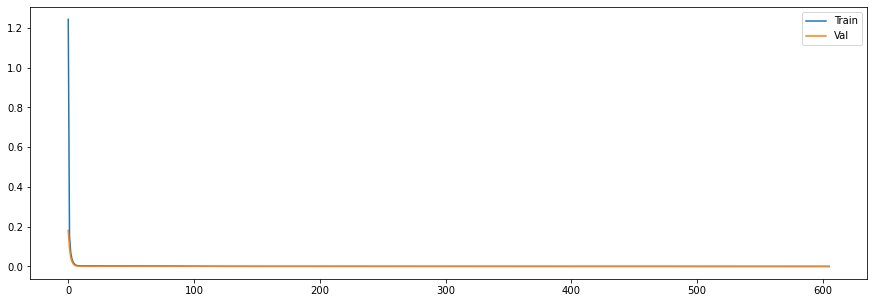

In [123]:
plotCompare(history.history['loss'],history.history['val_loss'],["Train","Val"])

In [124]:
if singleshot: 
    predictionsT=StepForwardPredictions(trainx,model,lookAhead)
    predictions=StepForwardPredictions(vx,model,lookAhead)
else: 
    predictionsT=model.predict(trainx)
    predictions=model.predict(vx)
benchmarker.loc[benchmarker.index.max()+1]=0
benchmarker.loc[benchmarker.index.max()]["model"]="DNN"
benchmarker.loc[benchmarker.index.max()]["1-Shot"]=singleshot
benchmarker.iloc[benchmarker.index.max(),2:]=np.array([evaluatePredictions(trainy,predictionsT),evaluatePredictions(vy,predictions)]).reshape(-1,order='C')

In [125]:
df1=pd.DataFrame(reverseOutputTransform(predictions,vk,logged=False,scaled=True).reshape(-1,lookAhead))
df2=pd.DataFrame(reverseOutputTransform(vy,vk,logged=False,scaled=True).reshape(-1,lookAhead))

In [126]:
fromN,toN=60,70

<AxesSubplot:>

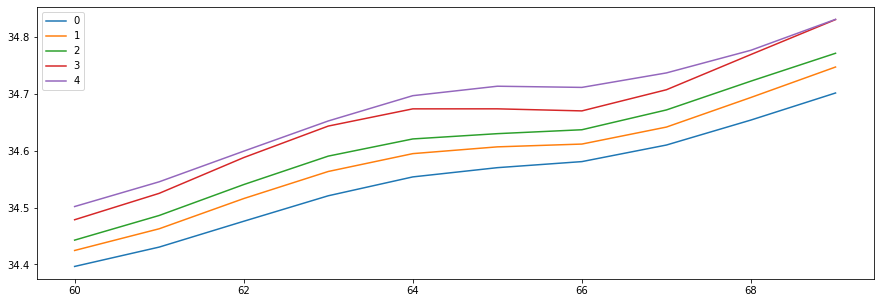

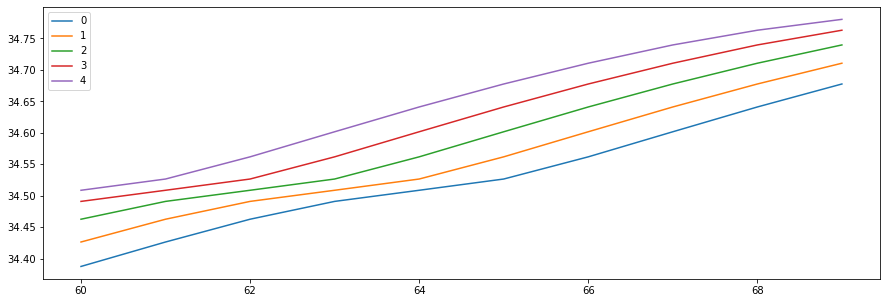

In [127]:
df1.iloc[fromN:toN].plot()
df2.iloc[fromN:toN].plot()

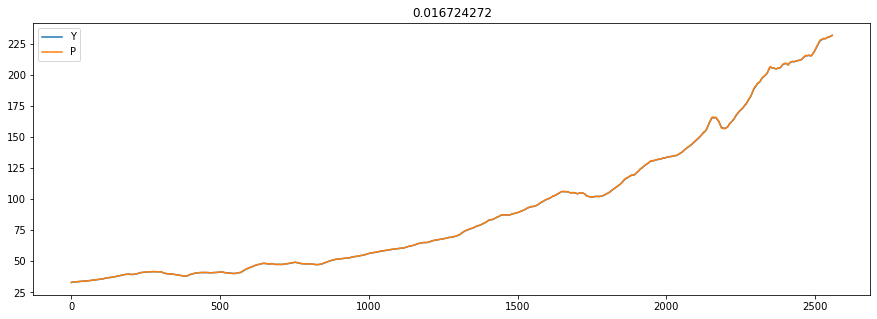

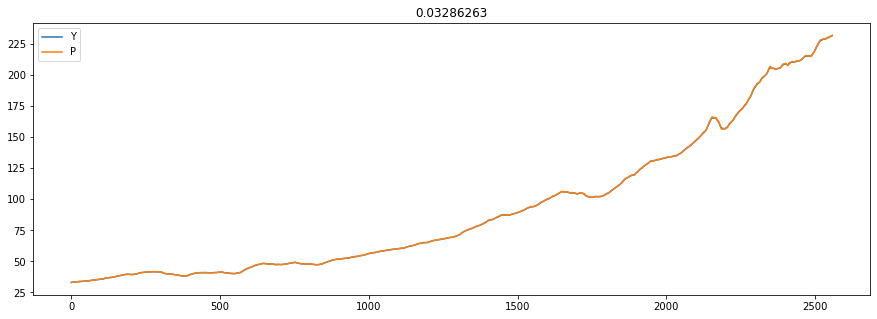

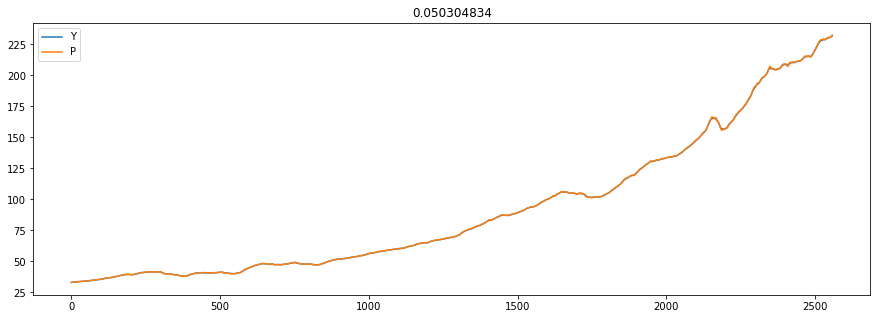

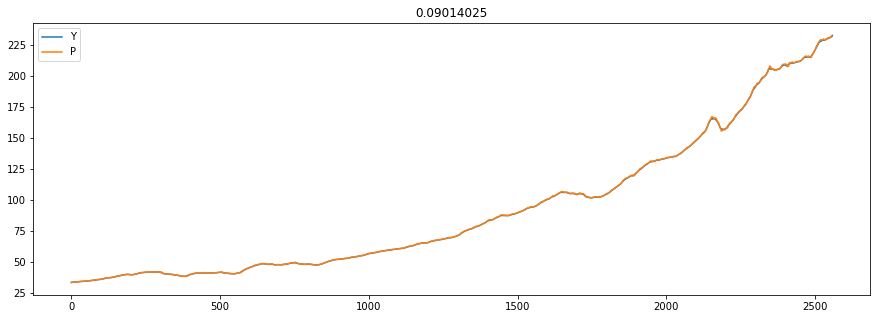

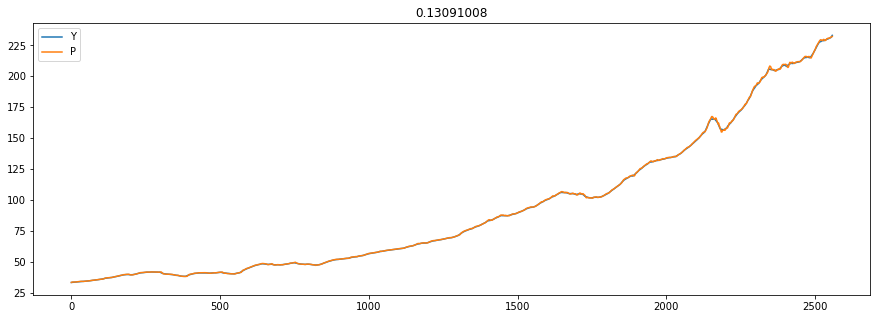

Shape  : (2559, 5, 1)
loss   : 11443.7158203125
MSE    : 0.057306503367537426 
RMSE   : 0.2393877677901221 
NMSE   : 0.0011960086412509047 
DS     : 0.8645817044566068 
WDS    : 0.004319548985911909 
Samples: 2559


In [128]:
plotAndEvaluate(reverseOutputTransform(vy,vk,logged=False,scaled=True),reverseOutputTransform(predictions,vk,logged=False,scaled=True))

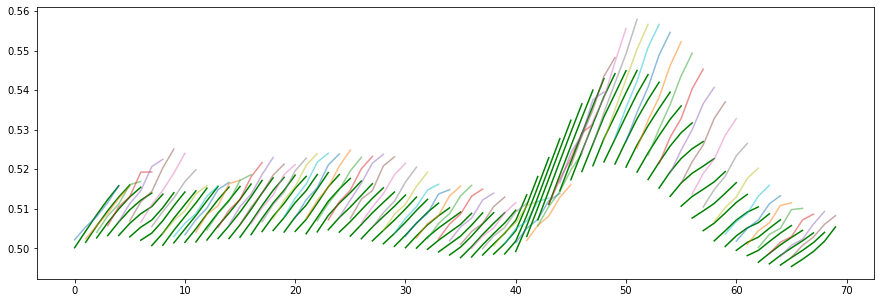

In [129]:
rrr=66
shiftff=66
plotMultVariate(vy[rrr:rrr+shiftff],predictions[rrr:rrr+shiftff],5)
# plotVisual(vy,predictions,lookAhead,0.001)

### Transformer

In [130]:
tf.keras.backend.clear_session()
def Transformer_Encoder_Model(inputShape=(period,1),model_dim=2, hidden=20,encoders=2,key_dim=2,axis=1,dropout=0.2,singleshot=False):
    if singleshot: outputSize=1
    else: outputSize=lookAhead
    x = Input(shape=inputShape)
    Ms= Masking()(x)
    E = ScalerMult(inputShape)(Ms)
    P = PositionalEncoding(inputShape[0], inputShape[1])(E)
    out=Encoder(model_dim,encoders,hidden,P,key_dim,dropout=dropout,axis=axis,epsilon=1e-7)
    out=Flatten()(out)
    out=Dense(outputSize,'elu')(out)
    out=Reshape([outputSize, 1])(out)
    return tf.keras.models.Model(inputs=x,outputs=out) 
model=Transformer_Encoder_Model(inputShape=trainx.shape[1:],model_dim=trainx.ndim-1, hidden=30,encoders=2,key_dim=2,axis=1,dropout=0.2,singleshot=singleshot)
history =compileFit(model,loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),epochs=10000,batch_size=500,patience=30,singleshot=singleshot)

Epoch 1/10000
21/21 [==============================] - 3s 29ms/step - loss: 0.8750 - val_loss: 0.9034
Epoch 2/10000
21/21 [==============================] - 0s 12ms/step - loss: 0.8140 - val_loss: 0.8385
Epoch 3/10000
21/21 [==============================] - 0s 12ms/step - loss: 0.7599 - val_loss: 0.7822
Epoch 4/10000
21/21 [==============================] - 0s 11ms/step - loss: 0.7143 - val_loss: 0.7337
Epoch 5/10000
21/21 [==============================] - 0s 11ms/step - loss: 0.6712 - val_loss: 0.6909
Epoch 6/10000
21/21 [==============================] - 0s 12ms/step - loss: 0.6319 - val_loss: 0.6521
Epoch 7/10000
21/21 [==============================] - 0s 12ms/step - loss: 0.5958 - val_loss: 0.6161
Epoch 8/10000
21/21 [==============================] - 0s 12ms/step - loss: 0.5612 - val_loss: 0.5820
Epoch 9/10000
21/21 [==============================] - 0s 12ms/step - loss: 0.5305 - val_loss: 0.5501
Epoch 10/10000
21/21 [==============================] - 0s 12ms/step - loss: 0.503

Epoch 80/10000
21/21 [==============================] - 0s 12ms/step - loss: 0.0176 - val_loss: 6.7760e-04
Epoch 81/10000
21/21 [==============================] - 0s 12ms/step - loss: 0.0171 - val_loss: 6.6880e-04
Epoch 82/10000
21/21 [==============================] - 0s 12ms/step - loss: 0.0169 - val_loss: 6.4387e-04
Epoch 83/10000
21/21 [==============================] - 0s 12ms/step - loss: 0.0167 - val_loss: 6.2698e-04
Epoch 84/10000
21/21 [==============================] - 0s 12ms/step - loss: 0.0165 - val_loss: 6.1485e-04
Epoch 85/10000
21/21 [==============================] - 0s 12ms/step - loss: 0.0162 - val_loss: 6.1590e-04
Epoch 86/10000
21/21 [==============================] - 0s 11ms/step - loss: 0.0156 - val_loss: 6.0245e-04
Epoch 87/10000
21/21 [==============================] - 0s 12ms/step - loss: 0.0154 - val_loss: 5.9214e-04
Epoch 88/10000
21/21 [==============================] - 0s 12ms/step - loss: 0.0152 - val_loss: 5.9841e-04
Epoch 89/10000
21/21 [===============

21/21 [==============================] - 0s 13ms/step - loss: 0.0052 - val_loss: 1.9305e-04
Epoch 157/10000
21/21 [==============================] - 0s 12ms/step - loss: 0.0050 - val_loss: 1.8778e-04
Epoch 158/10000
21/21 [==============================] - 0s 12ms/step - loss: 0.0050 - val_loss: 1.8167e-04
Epoch 159/10000
21/21 [==============================] - 0s 13ms/step - loss: 0.0050 - val_loss: 1.8141e-04
Epoch 160/10000
21/21 [==============================] - 0s 13ms/step - loss: 0.0048 - val_loss: 1.8211e-04
Epoch 161/10000
21/21 [==============================] - 0s 12ms/step - loss: 0.0047 - val_loss: 1.7521e-04
Epoch 162/10000
21/21 [==============================] - 0s 12ms/step - loss: 0.0047 - val_loss: 1.6960e-04
Epoch 163/10000
21/21 [==============================] - 0s 11ms/step - loss: 0.0046 - val_loss: 1.7865e-04
Epoch 164/10000
21/21 [==============================] - 0s 12ms/step - loss: 0.0046 - val_loss: 1.6998e-04
Epoch 165/10000
21/21 [=====================

21/21 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 9.3435e-05
Epoch 233/10000
21/21 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 8.9882e-05
Epoch 234/10000
21/21 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 8.8355e-05
Epoch 235/10000
21/21 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 8.8001e-05
Epoch 236/10000
21/21 [==============================] - 0s 12ms/step - loss: 0.0019 - val_loss: 8.6440e-05
Epoch 237/10000
21/21 [==============================] - 0s 12ms/step - loss: 0.0019 - val_loss: 9.1255e-05
Epoch 238/10000
21/21 [==============================] - 0s 12ms/step - loss: 0.0019 - val_loss: 9.4317e-05
Epoch 239/10000
21/21 [==============================] - 0s 12ms/step - loss: 0.0019 - val_loss: 9.0378e-05
Epoch 240/10000
21/21 [==============================] - 0s 12ms/step - loss: 0.0019 - val_loss: 9.1196e-05
Epoch 241/10000
21/21 [=====================

Epoch 308/10000
21/21 [==============================] - 0s 13ms/step - loss: 9.5264e-04 - val_loss: 7.7753e-05
Epoch 309/10000
21/21 [==============================] - 0s 12ms/step - loss: 9.5334e-04 - val_loss: 8.0736e-05
Epoch 310/10000
21/21 [==============================] - 0s 12ms/step - loss: 9.5755e-04 - val_loss: 7.8798e-05
Epoch 311/10000
21/21 [==============================] - 0s 12ms/step - loss: 9.5619e-04 - val_loss: 8.1151e-05
Epoch 312/10000
21/21 [==============================] - 0s 12ms/step - loss: 9.4152e-04 - val_loss: 8.2057e-05
Epoch 313/10000
21/21 [==============================] - 0s 11ms/step - loss: 9.2130e-04 - val_loss: 7.6784e-05
Epoch 314/10000
21/21 [==============================] - 0s 11ms/step - loss: 9.2701e-04 - val_loss: 7.6597e-05
Epoch 315/10000
21/21 [==============================] - 0s 12ms/step - loss: 9.0831e-04 - val_loss: 7.9928e-05
Epoch 316/10000
21/21 [==============================] - 0s 12ms/step - loss: 9.1210e-04 - val_loss: 8.0

21/21 [==============================] - 0s 13ms/step - loss: 3.2843e-04 - val_loss: 6.6796e-05
Epoch 455/10000
21/21 [==============================] - 0s 12ms/step - loss: 3.2587e-04 - val_loss: 6.7297e-05
Epoch 456/10000
21/21 [==============================] - 0s 12ms/step - loss: 3.3165e-04 - val_loss: 6.8254e-05
Epoch 457/10000
21/21 [==============================] - 0s 12ms/step - loss: 3.1799e-04 - val_loss: 6.5537e-05
Epoch 458/10000
21/21 [==============================] - 0s 13ms/step - loss: 3.1284e-04 - val_loss: 6.5828e-05
Epoch 459/10000
21/21 [==============================] - 0s 12ms/step - loss: 3.2009e-04 - val_loss: 6.6060e-05
Epoch 460/10000
21/21 [==============================] - 0s 13ms/step - loss: 3.3109e-04 - val_loss: 6.4860e-05
Epoch 461/10000
21/21 [==============================] - 0s 12ms/step - loss: 3.1126e-04 - val_loss: 6.9762e-05
Epoch 462/10000
21/21 [==============================] - 0s 13ms/step - loss: 3.1945e-04 - val_loss: 6.6687e-05
Epoch 46

21/21 [==============================] - 0s 12ms/step - loss: 1.6908e-04 - val_loss: 5.0676e-05
Epoch 601/10000
21/21 [==============================] - 0s 12ms/step - loss: 1.6166e-04 - val_loss: 5.0966e-05
Epoch 602/10000
21/21 [==============================] - 0s 11ms/step - loss: 1.6782e-04 - val_loss: 5.0774e-05
Epoch 603/10000
21/21 [==============================] - 0s 12ms/step - loss: 1.6218e-04 - val_loss: 5.1318e-05
Epoch 604/10000
21/21 [==============================] - 0s 13ms/step - loss: 1.6355e-04 - val_loss: 5.0935e-05
Epoch 605/10000
21/21 [==============================] - 0s 12ms/step - loss: 1.6549e-04 - val_loss: 5.0957e-05
Epoch 606/10000
21/21 [==============================] - 0s 12ms/step - loss: 1.6556e-04 - val_loss: 5.0559e-05
Epoch 607/10000
21/21 [==============================] - 0s 13ms/step - loss: 1.6721e-04 - val_loss: 5.0408e-05
Epoch 608/10000
21/21 [==============================] - 0s 12ms/step - loss: 1.6500e-04 - val_loss: 5.0558e-05
Epoch 60

21/21 [==============================] - 0s 12ms/step - loss: 1.2002e-04 - val_loss: 4.1080e-05
Epoch 747/10000
21/21 [==============================] - 0s 12ms/step - loss: 1.1668e-04 - val_loss: 4.1698e-05
Epoch 748/10000
21/21 [==============================] - 0s 12ms/step - loss: 1.1616e-04 - val_loss: 4.0694e-05
Epoch 749/10000
21/21 [==============================] - 0s 12ms/step - loss: 1.1883e-04 - val_loss: 4.3332e-05
Epoch 750/10000
21/21 [==============================] - 0s 12ms/step - loss: 1.1796e-04 - val_loss: 4.0868e-05
Epoch 751/10000
21/21 [==============================] - 0s 12ms/step - loss: 1.1944e-04 - val_loss: 4.1252e-05
Epoch 752/10000
21/21 [==============================] - 0s 13ms/step - loss: 1.1208e-04 - val_loss: 4.1678e-05
Epoch 753/10000
21/21 [==============================] - 0s 12ms/step - loss: 1.1676e-04 - val_loss: 4.0736e-05
Epoch 754/10000
21/21 [==============================] - 0s 12ms/step - loss: 1.1723e-04 - val_loss: 3.9873e-05
Epoch 75

21/21 [==============================] - 0s 12ms/step - loss: 9.6633e-05 - val_loss: 3.5157e-05
Epoch 893/10000
21/21 [==============================] - 0s 12ms/step - loss: 9.7246e-05 - val_loss: 3.6941e-05
Epoch 894/10000
21/21 [==============================] - 0s 13ms/step - loss: 9.6874e-05 - val_loss: 3.4911e-05
Epoch 895/10000
21/21 [==============================] - 0s 12ms/step - loss: 9.6128e-05 - val_loss: 3.4928e-05
Epoch 896/10000
21/21 [==============================] - 0s 12ms/step - loss: 9.6428e-05 - val_loss: 3.5569e-05
Epoch 897/10000
21/21 [==============================] - 0s 12ms/step - loss: 9.5693e-05 - val_loss: 3.4852e-05
Epoch 898/10000
21/21 [==============================] - 0s 12ms/step - loss: 9.8949e-05 - val_loss: 3.4811e-05
Epoch 899/10000
21/21 [==============================] - 0s 12ms/step - loss: 9.6134e-05 - val_loss: 3.4776e-05
Epoch 900/10000
21/21 [==============================] - 0s 13ms/step - loss: 9.4141e-05 - val_loss: 3.4746e-05
Epoch 90

Epoch 1038/10000
21/21 [==============================] - 0s 13ms/step - loss: 8.4648e-05 - val_loss: 3.2217e-05
Epoch 1039/10000
21/21 [==============================] - 0s 12ms/step - loss: 8.5087e-05 - val_loss: 3.1959e-05
Epoch 1040/10000
21/21 [==============================] - 0s 12ms/step - loss: 8.5100e-05 - val_loss: 3.2393e-05
Epoch 1041/10000
21/21 [==============================] - 0s 12ms/step - loss: 8.4256e-05 - val_loss: 3.1785e-05
Epoch 1042/10000
21/21 [==============================] - 0s 12ms/step - loss: 8.4011e-05 - val_loss: 3.2245e-05
Epoch 1043/10000
21/21 [==============================] - 0s 12ms/step - loss: 8.7543e-05 - val_loss: 3.2716e-05
Epoch 1044/10000
21/21 [==============================] - 0s 12ms/step - loss: 8.3470e-05 - val_loss: 3.3761e-05
Epoch 1045/10000
21/21 [==============================] - 0s 12ms/step - loss: 8.3664e-05 - val_loss: 3.2244e-05
Epoch 1046/10000
21/21 [==============================] - 0s 12ms/step - loss: 8.6461e-05 - val_

21/21 [==============================] - 0s 13ms/step - loss: 7.8290e-05 - val_loss: 3.0720e-05
Epoch 1183/10000
21/21 [==============================] - 0s 14ms/step - loss: 7.9389e-05 - val_loss: 3.0304e-05
Epoch 1184/10000
21/21 [==============================] - 0s 13ms/step - loss: 7.8433e-05 - val_loss: 3.0344e-05
Epoch 1185/10000
21/21 [==============================] - 0s 13ms/step - loss: 7.6324e-05 - val_loss: 3.0692e-05
Epoch 1186/10000
21/21 [==============================] - 0s 12ms/step - loss: 7.8466e-05 - val_loss: 3.1062e-05
Epoch 1187/10000
21/21 [==============================] - 0s 12ms/step - loss: 7.9003e-05 - val_loss: 3.0806e-05
Epoch 1188/10000
21/21 [==============================] - 0s 12ms/step - loss: 7.9298e-05 - val_loss: 3.0453e-05
Epoch 1189/10000
21/21 [==============================] - 0s 12ms/step - loss: 7.7982e-05 - val_loss: 3.0907e-05
Epoch 1190/10000
21/21 [==============================] - 0s 13ms/step - loss: 7.9505e-05 - val_loss: 3.0362e-05


21/21 [==============================] - 0s 13ms/step - loss: 7.8596e-05 - val_loss: 2.9605e-05
Epoch 1327/10000
21/21 [==============================] - 0s 13ms/step - loss: 7.2515e-05 - val_loss: 2.9907e-05
Epoch 1328/10000
21/21 [==============================] - 0s 13ms/step - loss: 7.1095e-05 - val_loss: 2.9728e-05
Epoch 1329/10000
21/21 [==============================] - 0s 13ms/step - loss: 7.6037e-05 - val_loss: 2.9781e-05
Epoch 1330/10000
21/21 [==============================] - 0s 13ms/step - loss: 7.5356e-05 - val_loss: 2.9476e-05
Epoch 1331/10000
21/21 [==============================] - 0s 14ms/step - loss: 7.2435e-05 - val_loss: 3.0152e-05
Epoch 1332/10000
21/21 [==============================] - 0s 13ms/step - loss: 7.6163e-05 - val_loss: 3.0013e-05
Epoch 1333/10000
21/21 [==============================] - 0s 12ms/step - loss: 7.5835e-05 - val_loss: 2.9782e-05
Epoch 1334/10000
21/21 [==============================] - 0s 12ms/step - loss: 7.8107e-05 - val_loss: 2.9763e-05


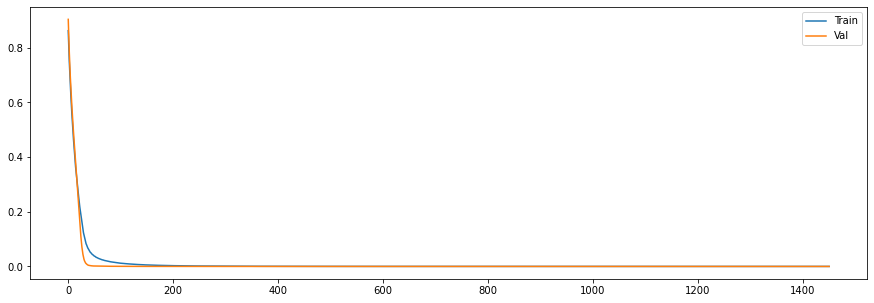

In [131]:
plotCompare(history.history['loss'],history.history['val_loss'],["Train","Val"])

In [132]:
if singleshot: 
    predictionsT=StepForwardPredictions(trainx,model,lookAhead)
    predictions=StepForwardPredictions(vx,model,lookAhead)
else: 
    predictionsT=model.predict(trainx)
    predictions=model.predict(vx)
benchmarker.loc[benchmarker.index.max()+1]=0
benchmarker.loc[benchmarker.index.max()]["model"]="TFENC"
benchmarker.loc[benchmarker.index.max()]["1-Shot"]=singleshot
benchmarker.iloc[benchmarker.index.max(),2:]=np.array([evaluatePredictions(trainy,predictionsT),evaluatePredictions(vy,predictions)]).reshape(-1,order='C')

In [133]:
df1=pd.DataFrame(reverseOutputTransform(predictions,vk,logged=False,scaled=True).reshape(-1,lookAhead))
df2=pd.DataFrame(reverseOutputTransform(vy,vk,logged=False,scaled=True).reshape(-1,lookAhead))

In [134]:
fromN,toN=60,70

<AxesSubplot:>

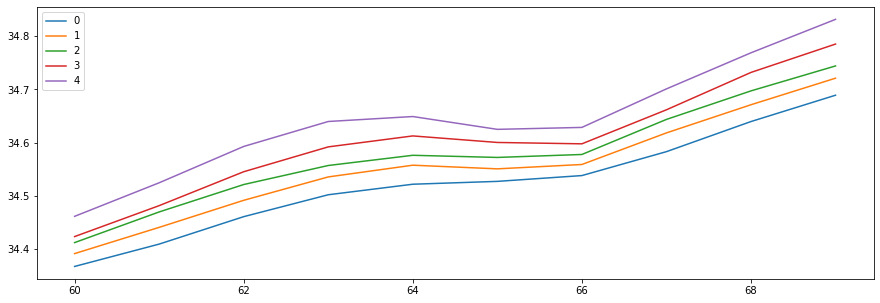

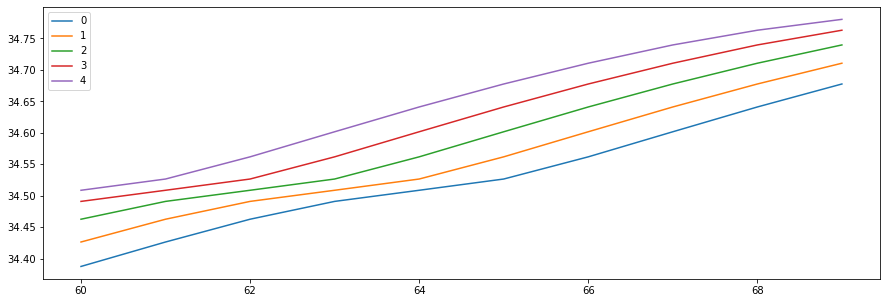

In [135]:
df1.iloc[fromN:toN].plot()
df2.iloc[fromN:toN].plot()

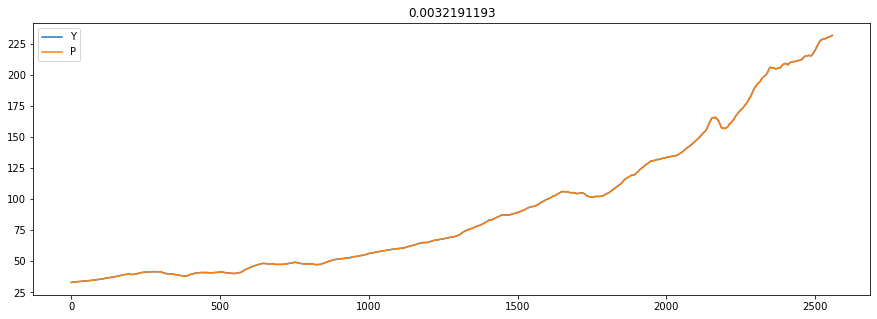

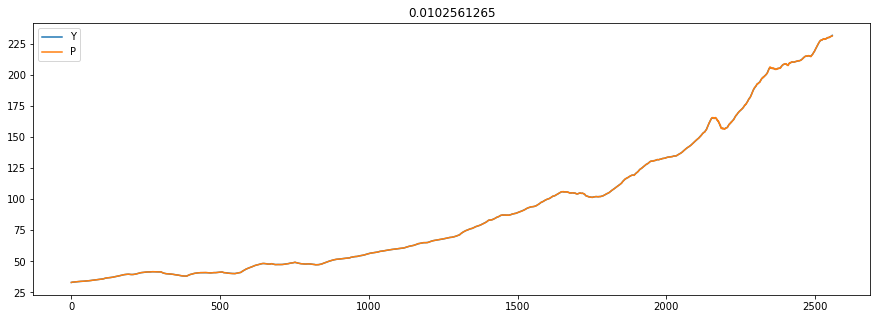

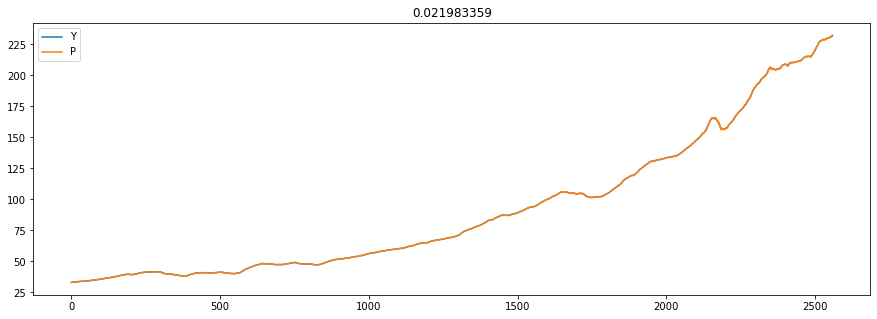

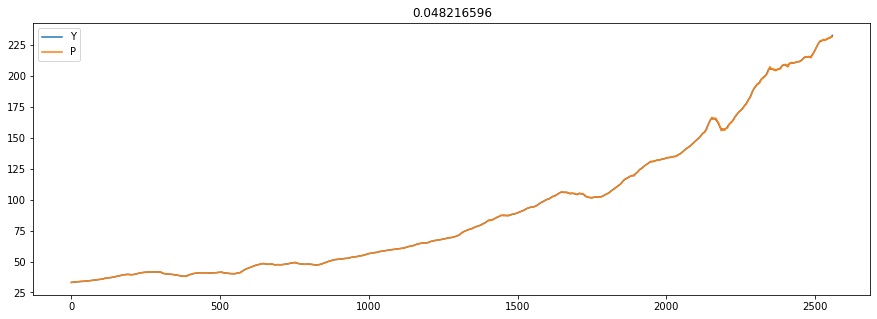

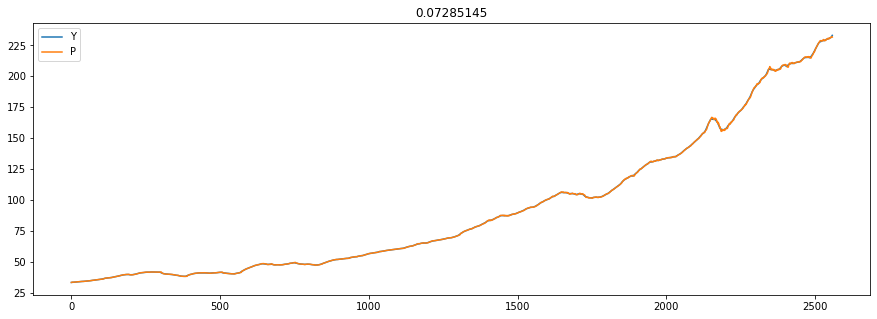

Shape  : (2559, 5, 1)
loss   : 11444.5263671875
MSE    : 0.025330048087249476 
RMSE   : 0.1591541645300225 
NMSE   : 0.0007951523915618782 
DS     : 0.8515246286161063 
WDS    : 0.004254314343060825 
Samples: 2559


In [136]:
plotAndEvaluate(reverseOutputTransform(vy,vk,logged=False,scaled=True),reverseOutputTransform(predictions,vk,logged=False,scaled=True))

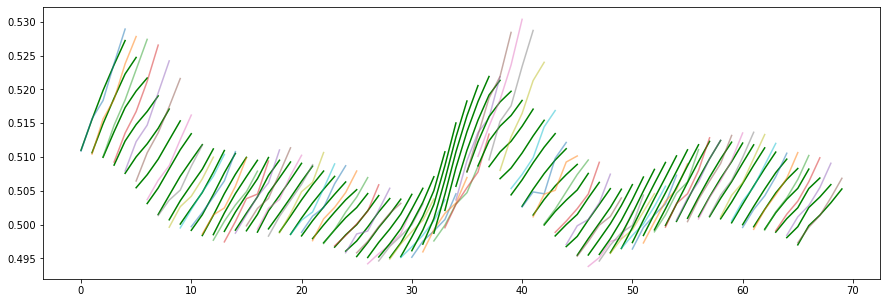

In [137]:
rrr=1000
shiftff=66
plotMultVariate(vy[rrr:rrr+shiftff],predictions[rrr:rrr+shiftff],lookAhead)
# plotVisual(vy,predictions,lookAhead,0.001)

In [139]:
benchmarker.sort_values(by="Val_t4")

,model,1-Shot,Train_t0,Train_t1,Train_t2,Train_t3,Train_t4,Val_t0,Val_t1,Val_t2,Val_t3,Val_t4
14,TFENC,False,0.000006,0.000019,0.000045,0.000104,0.000164,0.000003,0.000009,0.00002,0.000045,0.000069
10,RESLSTM,False,0.000027,0.000019,0.000071,0.000107,0.000162,0.000024,0.000009,0.000043,0.000049,0.000072
11,BILSTM,False,0.00001,0.000029,0.000064,0.000117,0.000195,0.000005,0.000014,0.000027,0.000049,0.000081
8,RNN,False,0.000008,0.000027,0.000057,0.000116,0.0002,0.000006,0.000016,0.000027,0.000056,0.000097
12,CONVLSTM,False,0.00002,0.000058,0.000109,0.000183,0.000287,0.00001,0.000029,0.000049,0.000077,0.000123
13,DNN,False,0.000027,0.000054,0.000093,0.000159,0.000249,0.000016,0.000032,0.000048,0.000087,0.000124
9,0,False,0.000164,0.000239,0.000344,0.000497,0.000688,0.00014,0.000182,0.000247,0.000352,0.000482
0,RepeatBL,NaN,0.000053,0.000211,0.00047,0.000828,0.001284,0.000021,0.000081,0.000181,0.000317,0.000491
5,CONVLSTM,True,0.000023,0.000108,0.000401,0.001147,0.002719,0.00001,0.000043,0.000156,0.00044,0.001034
4,BILSTM,True,0.000031,0.000152,0.000661,0.001928,0.004417,0.000018,0.00004,0.000179,0.000556,0.00135


# Applying Sentiment to our models 

In [338]:
dataSubset=getQueryFromMongoDB("ProcessedTweets",query={"stockInfo":"TSLA"},fields=["processed","dateCreated","followers","retweets","likes","positive","negative"]).sort_values('dateCreated')
dataSubset=dataSubset.drop_duplicates(subset=['processed'], keep='last')
# dataSubset=dataSubset.drop(columns="processed")
# dataSubset["dateCreated"]=dataSubset["dateCreated"].apply(lambda x:x.date())
dataSubset["ratio"]=(dataSubset["followers"]*dataSubset["retweets"])/dataSubset["likes"]
dataSubset["PM"]=dataSubset["positive"]*dataSubset["ratio"]
dataSubset["NM"]=dataSubset["negative"]*dataSubset["ratio"]
dataSubset=dataSubset.set_index(pd.to_datetime(dataSubset["dateCreated"], unit='D',utc=True))

In [340]:
dataSubset.to_csv("check.csv")

In [140]:
r=dataSubset.resample('d').first().ffill().resample('d').sum()
r.replace([np.inf, -np.inf],[r[["NM","PM"]].max().max(),r[["NM","PM"]].min().min()], inplace=True)

<AxesSubplot:xlabel='dateCreated'>

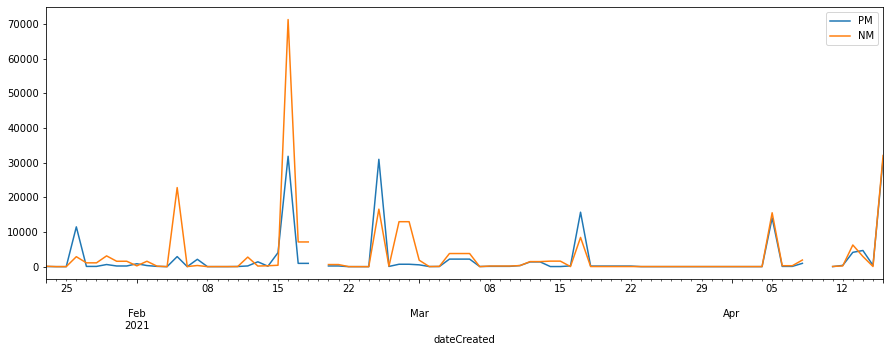

In [143]:
r[["PM","NM"]].plot()

In [146]:
data

,Close,InOut
Date,,
2010-06-29,4.778000,4.778000
2010-06-30,4.766000,4.771931
2010-07-01,4.392000,4.642350
2010-07-02,3.840000,4.434758
2010-07-03,3.472546,4.233322
...,...,...
2021-03-27,602.264747,695.244744
2021-03-28,599.881921,693.066654
2021-03-29,611.289978,691.198872


In [ ]:
pss.resample('D').first()
# data["wasNa"]=data['Close'].isna()#mark filled in spots for future reference
# print(data["wasNa"].value_counts())

In [145]:
pss["sentiment"]=model.predict(pss["body"].values)

NameError: name 'pss' is not defined

In [ ]:
pss["sentiment"]=pss["sentiment"].replace({0:-1,2:1})

In [ ]:
# pss.set_index(pd.to_datetime(pss.index, unit='d',utc=True).dt.date)

In [ ]:
# TSLA=load("TSLA")
# TSLA=loadStockData(stock)
print(tweetdata.index.min(), tweetdata.index.max())
print(TSLA.index.min(), TSLA.index.max())
mini,maxi=None,None
if tweetdata.index.min()>TSLA.index.min(): mini=tweetdata.index.min()
else: mini= TSLA.index.min()
if tweetdata.index.max()>TSLA.index.max(): mini=TSLA.index.max()
else: maxi= tweetdata.index.max()
print(mini,"-",maxi)

In [ ]:
# check if stock has relationship with sentiment
# check if sentiment compenent works well
# check if sentiment compenent improves stock predictions 
# check if fill in and check missing data in time series problems
# check how roll calculates missing values 

In [ ]:
pss

In [ ]:
# tslaTweets=tweetdata[tweetdata["body"].str.contains("tsla|tesla", case=False, na=None, regex=True)]
# tslaTweets["sentiment"]=model.predict(tslaTweets["body"])
# tslaTweets["good"],tslaTweets["bad"]=tslaTweets["sentiment"].apply(lambda x: x==4 and 1 or 0),tslaTweets["sentiment"].apply(lambda x: x==0 and 1 or 0)
# tslaTweets=tslaTweets.groupby(tslaTweets.index).sum()
# tslaTweets=tslaTweets.set_index(pd.to_datetime(tslaTweets.index))

In [ ]:
pss["good"],pss["bad"]=pss["sentiment"].apply(lambda x: x==1 and 1 or 0),pss["sentiment"].apply(lambda x: x==-1 and 1 or 0)
pss=pss.groupby(pss.index).sum()
pss=pss.set_index(pd.to_datetime(pss.index))
pss

In [ ]:
pss["diff"]=pss["good"]-pss["bad"]
pss["str"]=pss["diff"]/(pss["good"]+pss["bad"])
pss["sign"]=np.sign(pss["diff"])
pss["change"]=(pss["diff"]-pss["diff"].shift(1)).fillna(0)
pss["changeS"]=np.sign(pss["change"])
pss=pss.resample('D').first()
pss=pss.ffill()

In [ ]:
# tslaTweets
# findMissingInterval(tslaTweets)

In [ ]:
# slices.drop(columns=['sentiment'], inplace=True)
tslaTweets["diff"]=tslaTweets["good"]-tslaTweets["bad"]
tslaTweets["str"]=tslaTweets["diff"]/(tslaTweets["good"]+tslaTweets["bad"])
tslaTweets["sign"]=np.sign(tslaTweets["diff"])
tslaTweets["change"]=(tslaTweets["diff"]-tslaTweets["diff"].shift(1)).fillna(0)
tslaTweets["changeS"]=np.sign(tslaTweets["change"])
tslaTweets=tslaTweets.resample('D').first()
tslaTweets=tslaTweets.ffill()

In [ ]:
pss.index.max(),pss.index.min(),TSLA.index.max(),TSLA.index.min()

In [ ]:
mini=pss.index.min()
maxi=pss.index.max()

In [ ]:
fromD=mini+ timedelta(days=12)
to=mini+ timedelta(days=360)
common=pd.merge(left=data, left_index=True, right=pss, right_index=True)
commonr=common.rolling(12).mean().dropna()
commonr[fromD:to][["Close"]].plot(xlim=(fromD,to))
commonr[fromD:to][["change","diff"]].plot(xlim=(fromD,to))
commonr[fromD:to][["str","changeS"]].plot(xlim=(fromD,to))
commonr[fromD:to][['good', 'bad', 'diff', 'str', 'change']].plot(xlim=(fromD,to))

In [ ]:
commonr

# Results

In [ ]:
# dataIn,dataOut=createTimeSeriesData(commonr[["Close","sentiment"]],outputColumns=["Close"],outputlengthTimeSteps=lookAhead,shifts=period)
# dataIn=(dataIn.to_numpy().reshape(dataIn.shape[0],period,-1))
# dataOut=(dataOut.to_numpy().reshape(dataOut.shape[0],lookAhead,-1))
# split=0.2
trainx,vtx,trainy,vty=train_test_split(dataIn,dataOut,test_size=split,shuffle=False)
vx,tx,vy,ty=train_test_split(vtx,vty,test_size=0.5,shuffle=False)
print("Total Samples:",len(dataIn),"\t\t\tTraining Samples:",len(trainx))
print("Total Validation Samples:",len(vy),"\t\tTest Samples:",len(ty))
print("Input Data Shape:",tx.shape[1:],"\t\tOutput Data Shape:",ty.shape[1:])

In [ ]:
trainx,vtx,trainy,vty=train_test_split(data[:-1][["Close"]].values.reshape(-1,1,1),data[:-1][["Close"]].values.reshape(-1,1,1),test_size=0.2,shuffle=False)